In [1000]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
import numpy as np

import matplotlib.pyplot as plt

import src.layers as layers
import src.util as util
import src.networks as networks

import importlib
import seaborn as sns

%matplotlib inline

In [1001]:
importlib.reload(layers)
importlib.reload(util)
importlib.reload(networks)

<module 'src.networks' from '/Users/beaucoker/Documents/Harvard_Biostat/summer 2019/src/networks.py'>

In [1002]:
l = layers.HSLayer_type3(1,6,1,1)
#l = layers.HSOutputLayer(1,6,1)
x = torch.empty((5,1)).normal_(0,1)

In [1003]:
l.entropy()

tensor(-65.3886, grad_fn=<AddBackward0>)

In [1004]:
l.cross_entropy()

tensor(61.4612, grad_fn=<AddBackward0>)

In [1005]:
l.kl_divergence()

tensor(126.8497, grad_fn=<SubBackward0>)

In [1006]:
# Toy data
x_true = torch.tensor(np.linspace(-5,5,100).reshape(-1,1), dtype=torch.float)
x, x_val, y, y_val, y_scale, y_true = util.gen_toy_data(x_true=x_true)

In [1010]:
def plot_varbnn(bnn, n_samp, x_true, name):
    y_samps=np.array([bnn(x_true, sample=True).view(-1).detach().numpy() for _ in range(n_samp)])
    sns.tsplot(y_samps, time=x_true.numpy(),ci='sd',color='red')
    plt.scatter(x.numpy(),y.numpy(), color='k', alpha=.5)
    plt.plot(x_true.numpy(),y_true.numpy(), color='k')
    plt.legend(['Truth','BNN'])
    #plt.title('%s\n ELBO=%.3f' % (name))
    plt.xlabel('x')
    plt.ylabel('y')   

In [1012]:
def run_toy(layer_type, n_restarts, n_epochs):
    elbo = np.zeros((n_epochs, n_restarts))

    for i in range(n_restarts):
        torch.manual_seed(i)
        
        bnn = networks.BNN(x.shape[1],y.shape[1], activation_type='relu', dim_hidden=20, n_layers=1, sig2=sigma_y**2)
        optimizer = torch.optim.Adam(bnn.parameters(), lr=.001)
        
        bnn.reinit_parameters(x,y,n_reinit=10)
        elbo[:,i] = -networks.train(bnn, optimizer, x, y, n_epochs=n_epochs, print_freq=1000)


    # Find best model
    i_epoch_best, i_restart_best = np.unravel_index(elbo.argmax(), elbo.shape)
    
    # Retrain best model
    #torch.manual_seed(i_restart_best)
    #varbnn = networks.VariationalBNN(1,1,.01, layer_type=layer_type, activation_type='tanh', dim_hidden=100, n_layers=1, sigma_y=.1)
    #varbnn.train(x,y,n_epochs=i_epoch_best, print_freq=2000)

    
    return bnn, elbo



In [1013]:
bnn, elbo = run_toy(layer_type='bbb', n_restarts=1, n_epochs=10000)


Epoch[1000/10000], kl: 1748.421509, elbo: -33.052925
Epoch[2000/10000], kl: 1119.534546, elbo: -26.731659
Epoch[3000/10000], kl: 880.101624, elbo: -23.352024
Epoch[4000/10000], kl: 767.496582, elbo: -21.085880
Epoch[5000/10000], kl: 711.111023, elbo: -20.050377
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[6000/10000], kl: 675.860657, elbo: -20.272770
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[7000/10000], kl: 651.783020, elbo: -19.301083
saving...
saving...
saving...
saving...
saving...
saving...
savi

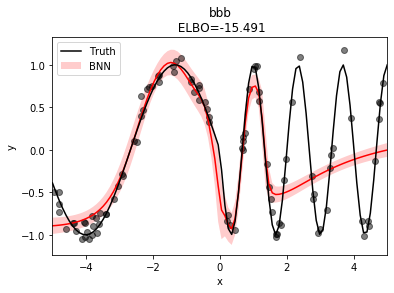

In [267]:
plot_varbnn(varbnn_bbb, 1000, x_true, "bbb", elbo_best_bbb)

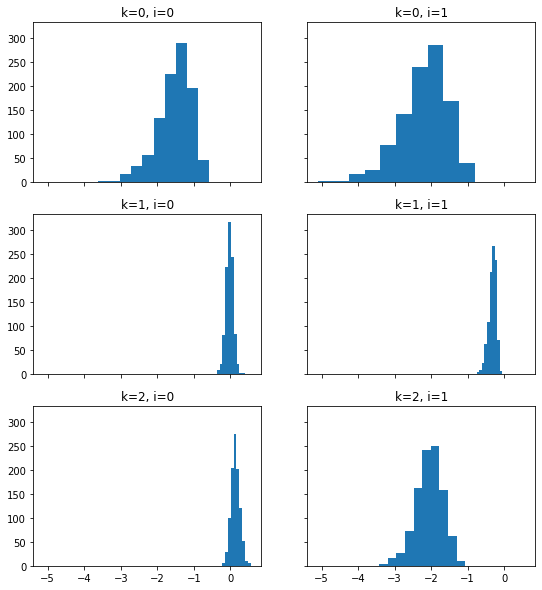

In [268]:
l = varbnn_bbb.bnn.fc1
#l = layers.HSSelectLayer(1,3,1,1)

w = l.sample_weights(1000)

units_show = 3

fig, ax = plt.subplots(units_show, l.dim_in, 
                       figsize=(3*units_show,5*l.dim_in),
                      sharex=True,sharey=True)

for k in range(units_show):
    for i in range(l.dim_in):
        ax[k,i].hist(w[k][:,i])
        ax[k,i].set_title('k=%d, i=%d'%(k,i))

## Variable selection dataset

In [1524]:
import seaborn as sns
importlib.reload(layers)
importlib.reload(util)
importlib.reload(networks)

<module 'src.networks' from '/Users/beaucoker/Documents/Harvard_Biostat/summer 2019/src/networks.py'>

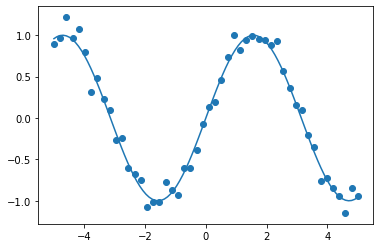

In [1408]:
np.random.seed(0)

n_obs =  50
sigma_y = 0.1

x1 = torch.linspace(-5,5,n_obs).reshape(-1,1)
x2 = torch.randn(n_obs).reshape(-1,1)
x3 = (torch.linspace(-5,5,n_obs) + 1*torch.randn(n_obs)).reshape(-1,1)
x4 = (torch.linspace(-5,5,n_obs) + 1*torch.randn(n_obs)).reshape(-1,1)
x5 = (torch.linspace(-5,5,n_obs) + 1*torch.randn(n_obs)).reshape(-1,1)
x = torch.cat((x1,x2,x3,x4,x5),1)

f = lambda x: torch.sin(x)
y = f(x1) + sigma_y * torch.randn(n_obs).reshape(-1,1)

plt.scatter(x1.numpy(), y.numpy())
plt.plot(np.linspace(-5,5,100), np.sin(np.linspace(-5,5,100)))

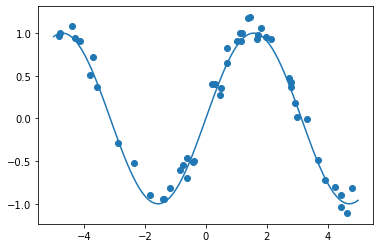

In [1502]:
np.random.seed(0)

n_obs =  50
sigma_y = 0.1

x = np.concatenate((
    np.random.uniform(-5,5,n_obs).reshape(-1,1),
    np.random.uniform(-5,5,n_obs).reshape(-1,1)
), axis=1)

f = lambda x: np.sin(x)

y = (f(x[:,0]) + sigma_y * np.random.normal(0,1,n_obs)).reshape(-1,1)

plt.scatter(x[:,0], y)
x_grid = np.linspace(-5,5,100)
plt.plot(x_grid, f(x_grid))

x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()

In [1535]:
# Train BNN
torch.manual_seed(6)

#bnn = networks.BNN(x.shape[1],y.shape[1], activation_type='relu', dim_hidden=20, n_layers=1, sig2=sigma_y**2)

#bnn = networks.BNN(x.shape[1],y.shape[1], activation_type='relu', dim_hidden=20, n_layers=1, infer_noise=True, sig2_alpha_prior=1., sig2_beta_prior=sigma_y**2)

## E[sig2] set to truth (.01). Works for some temperatures
#bnn = networks.BNN(x.shape[1],y.shape[1], activation_type='relu', dim_hidden=20, n_layers=1, infer_noise=True, sig2_alpha_prior=2., sig2_beta_prior=sigma_y**2)

## sig2_alpha_prior and sig2_alpha_prior are small, as in paper
bnn = networks.BNN(x.shape[1],y.shape[1], activation_type='relu', dim_hidden=20, n_layers=1, infer_noise=True, sig2_alpha_prior=.001, sig2_beta_prior=.001)


optimizer = torch.optim.Adam(bnn.parameters(), lr=.001)


In [1536]:
sigma_y**2 # True variance (sig2)

0.010000000000000002

In [1537]:
bnn.sig2_beta_prior / (bnn.sig2_alpha_prior-1) # mean prior variance(sig2)

tensor(-0.0010)

In [1538]:
bnn.sig2_alpha_prior / (bnn.sig2_beta_prior) # mean prior precision(1/sig2)

tensor(1.)

In [1539]:
torch.manual_seed(0)
bnn.reinit_parameters(x,y,n_reinit=10)
loss = networks.train(bnn, optimizer, x, y, n_epochs=10000, n_warmup=5000, print_freq=1000)


E[sig2]: tensor(4.1665e-05)
E[sig2]: tensor(0.0002)
E[sig2]: tensor(0.0003)
E[sig2]: tensor(0.0004)
E[sig2]: tensor(0.0005)
E[sig2]: tensor(0.0006)
E[sig2]: tensor(0.0008)
E[sig2]: tensor(0.0009)
E[sig2]: tensor(0.0010)
E[sig2]: tensor(0.0011)
E[sig2]: tensor(0.0012)
E[sig2]: tensor(0.0013)
E[sig2]: tensor(0.0015)
E[sig2]: tensor(0.0016)
E[sig2]: tensor(0.0017)
E[sig2]: tensor(0.0018)
E[sig2]: tensor(0.0020)
E[sig2]: tensor(0.0021)
E[sig2]: tensor(0.0022)
E[sig2]: tensor(0.0023)
E[sig2]: tensor(0.0024)
E[sig2]: tensor(0.0025)
E[sig2]: tensor(0.0027)
E[sig2]: tensor(0.0028)
E[sig2]: tensor(0.0029)
E[sig2]: tensor(0.0030)
E[sig2]: tensor(0.0031)
E[sig2]: tensor(0.0032)
E[sig2]: tensor(0.0033)
E[sig2]: tensor(0.0034)
E[sig2]: tensor(0.0036)
E[sig2]: tensor(0.0037)
E[sig2]: tensor(0.0038)
E[sig2]: tensor(0.0039)
E[sig2]: tensor(0.0041)
E[sig2]: tensor(0.0042)
E[sig2]: tensor(0.0043)
E[sig2]: tensor(0.0044)
E[sig2]: tensor(0.0045)
E[sig2]: tensor(0.0046)
E[sig2]: tensor(0.0048)
E[sig2]: ten

E[sig2]: tensor(0.0398)
E[sig2]: tensor(0.0401)
E[sig2]: tensor(0.0404)
E[sig2]: tensor(0.0404)
E[sig2]: tensor(0.0404)
E[sig2]: tensor(0.0405)
E[sig2]: tensor(0.0406)
E[sig2]: tensor(0.0405)
E[sig2]: tensor(0.0408)
E[sig2]: tensor(0.0410)
E[sig2]: tensor(0.0415)
E[sig2]: tensor(0.0412)
E[sig2]: tensor(0.0414)
E[sig2]: tensor(0.0413)
E[sig2]: tensor(0.0417)
E[sig2]: tensor(0.0414)
E[sig2]: tensor(0.0418)
E[sig2]: tensor(0.0422)
E[sig2]: tensor(0.0419)
E[sig2]: tensor(0.0420)
E[sig2]: tensor(0.0426)
E[sig2]: tensor(0.0424)
E[sig2]: tensor(0.0424)
E[sig2]: tensor(0.0425)
E[sig2]: tensor(0.0426)
E[sig2]: tensor(0.0430)
E[sig2]: tensor(0.0435)
E[sig2]: tensor(0.0432)
E[sig2]: tensor(0.0430)
E[sig2]: tensor(0.0432)
E[sig2]: tensor(0.0438)
E[sig2]: tensor(0.0432)
E[sig2]: tensor(0.0436)
E[sig2]: tensor(0.0436)
E[sig2]: tensor(0.0437)
E[sig2]: tensor(0.0440)
E[sig2]: tensor(0.0445)
E[sig2]: tensor(0.0443)
E[sig2]: tensor(0.0441)
E[sig2]: tensor(0.0444)
E[sig2]: tensor(0.0444)
E[sig2]: tensor(

E[sig2]: tensor(0.0794)
E[sig2]: tensor(0.0795)
E[sig2]: tensor(0.0799)
E[sig2]: tensor(0.0801)
E[sig2]: tensor(0.0800)
E[sig2]: tensor(0.0804)
E[sig2]: tensor(0.0804)
E[sig2]: tensor(0.0804)
E[sig2]: tensor(0.0803)
E[sig2]: tensor(0.0806)
E[sig2]: tensor(0.0809)
E[sig2]: tensor(0.0811)
E[sig2]: tensor(0.0810)
E[sig2]: tensor(0.0814)
E[sig2]: tensor(0.0811)
E[sig2]: tensor(0.0816)
E[sig2]: tensor(0.0815)
E[sig2]: tensor(0.0811)
E[sig2]: tensor(0.0819)
E[sig2]: tensor(0.0819)
E[sig2]: tensor(0.0820)
E[sig2]: tensor(0.0825)
E[sig2]: tensor(0.0824)
E[sig2]: tensor(0.0822)
E[sig2]: tensor(0.0822)
E[sig2]: tensor(0.0825)
E[sig2]: tensor(0.0825)
E[sig2]: tensor(0.0825)
E[sig2]: tensor(0.0825)
E[sig2]: tensor(0.0829)
E[sig2]: tensor(0.0830)
E[sig2]: tensor(0.0832)
E[sig2]: tensor(0.0832)
E[sig2]: tensor(0.0834)
E[sig2]: tensor(0.0835)
E[sig2]: tensor(0.0834)
E[sig2]: tensor(0.0839)
E[sig2]: tensor(0.0839)
E[sig2]: tensor(0.0838)
E[sig2]: tensor(0.0845)
E[sig2]: tensor(0.0841)
E[sig2]: tensor(

E[sig2]: tensor(0.1163)
E[sig2]: tensor(0.1166)
E[sig2]: tensor(0.1166)
E[sig2]: tensor(0.1165)
E[sig2]: tensor(0.1169)
E[sig2]: tensor(0.1171)
E[sig2]: tensor(0.1169)
E[sig2]: tensor(0.1169)
E[sig2]: tensor(0.1172)
E[sig2]: tensor(0.1174)
E[sig2]: tensor(0.1176)
E[sig2]: tensor(0.1175)
E[sig2]: tensor(0.1177)
E[sig2]: tensor(0.1182)
E[sig2]: tensor(0.1177)
E[sig2]: tensor(0.1180)
E[sig2]: tensor(0.1182)
E[sig2]: tensor(0.1181)
E[sig2]: tensor(0.1182)
E[sig2]: tensor(0.1184)
E[sig2]: tensor(0.1183)
E[sig2]: tensor(0.1185)
E[sig2]: tensor(0.1185)
E[sig2]: tensor(0.1185)
E[sig2]: tensor(0.1189)
E[sig2]: tensor(0.1197)
E[sig2]: tensor(0.1188)
E[sig2]: tensor(0.1188)
E[sig2]: tensor(0.1189)
E[sig2]: tensor(0.1193)
E[sig2]: tensor(0.1189)
E[sig2]: tensor(0.1192)
E[sig2]: tensor(0.1196)
E[sig2]: tensor(0.1197)
E[sig2]: tensor(0.1195)
E[sig2]: tensor(0.1198)
E[sig2]: tensor(0.1197)
E[sig2]: tensor(0.1198)
E[sig2]: tensor(0.1199)
E[sig2]: tensor(0.1208)
E[sig2]: tensor(0.1201)
E[sig2]: tensor(

E[sig2]: tensor(0.1408)
E[sig2]: tensor(0.1411)
E[sig2]: tensor(0.1399)
E[sig2]: tensor(0.1407)
E[sig2]: tensor(0.1410)
E[sig2]: tensor(0.1406)
E[sig2]: tensor(0.1413)
E[sig2]: tensor(0.1412)
E[sig2]: tensor(0.1401)
E[sig2]: tensor(0.1408)
E[sig2]: tensor(0.1408)
E[sig2]: tensor(0.1408)
E[sig2]: tensor(0.1399)
E[sig2]: tensor(0.1417)
E[sig2]: tensor(0.1409)
E[sig2]: tensor(0.1411)
E[sig2]: tensor(0.1420)
E[sig2]: tensor(0.1415)
E[sig2]: tensor(0.1406)
E[sig2]: tensor(0.1407)
E[sig2]: tensor(0.1406)
E[sig2]: tensor(0.1416)
E[sig2]: tensor(0.1414)
E[sig2]: tensor(0.1413)
E[sig2]: tensor(0.1409)
E[sig2]: tensor(0.1413)
E[sig2]: tensor(0.1409)
E[sig2]: tensor(0.1414)
E[sig2]: tensor(0.1409)
E[sig2]: tensor(0.1407)
E[sig2]: tensor(0.1417)
E[sig2]: tensor(0.1407)
E[sig2]: tensor(0.1415)
E[sig2]: tensor(0.1421)
E[sig2]: tensor(0.1410)
E[sig2]: tensor(0.1415)
E[sig2]: tensor(0.1409)
E[sig2]: tensor(0.1415)
E[sig2]: tensor(0.1418)
E[sig2]: tensor(0.1415)
E[sig2]: tensor(0.1417)
E[sig2]: tensor(

E[sig2]: tensor(0.1438)
E[sig2]: tensor(0.1400)
E[sig2]: tensor(0.1399)
E[sig2]: tensor(0.1370)
E[sig2]: tensor(0.1418)
E[sig2]: tensor(0.1402)
E[sig2]: tensor(0.1408)
E[sig2]: tensor(0.1371)
E[sig2]: tensor(0.1392)
E[sig2]: tensor(0.1378)
E[sig2]: tensor(0.1393)
E[sig2]: tensor(0.1379)
E[sig2]: tensor(0.1397)
E[sig2]: tensor(0.1382)
E[sig2]: tensor(0.1389)
E[sig2]: tensor(0.1399)
E[sig2]: tensor(0.1382)
E[sig2]: tensor(0.1385)
E[sig2]: tensor(0.1386)
E[sig2]: tensor(0.1402)
E[sig2]: tensor(0.1400)
E[sig2]: tensor(0.1409)
E[sig2]: tensor(0.1390)
E[sig2]: tensor(0.1420)
E[sig2]: tensor(0.1384)
E[sig2]: tensor(0.1396)
E[sig2]: tensor(0.1395)
E[sig2]: tensor(0.1392)
E[sig2]: tensor(0.1383)
E[sig2]: tensor(0.1393)
E[sig2]: tensor(0.1395)
E[sig2]: tensor(0.1414)
E[sig2]: tensor(0.1414)
E[sig2]: tensor(0.1429)
E[sig2]: tensor(0.1392)
E[sig2]: tensor(0.1386)
E[sig2]: tensor(0.1409)
E[sig2]: tensor(0.1421)
E[sig2]: tensor(0.1415)
E[sig2]: tensor(0.1417)
E[sig2]: tensor(0.1405)
E[sig2]: tensor(

E[sig2]: tensor(0.1595)
E[sig2]: tensor(0.1563)
E[sig2]: tensor(0.1548)
E[sig2]: tensor(0.1616)
E[sig2]: tensor(0.1533)
E[sig2]: tensor(0.1572)
E[sig2]: tensor(0.1542)
E[sig2]: tensor(0.1575)
E[sig2]: tensor(0.1627)
E[sig2]: tensor(0.1551)
E[sig2]: tensor(0.1587)
E[sig2]: tensor(0.1581)
E[sig2]: tensor(0.1539)
E[sig2]: tensor(0.1570)
E[sig2]: tensor(0.1546)
E[sig2]: tensor(0.1539)
E[sig2]: tensor(0.1613)
E[sig2]: tensor(0.1555)
E[sig2]: tensor(0.1546)
E[sig2]: tensor(0.1578)
E[sig2]: tensor(0.1564)
E[sig2]: tensor(0.1555)
E[sig2]: tensor(0.1562)
E[sig2]: tensor(0.1559)
E[sig2]: tensor(0.1588)
E[sig2]: tensor(0.1635)
E[sig2]: tensor(0.1562)
E[sig2]: tensor(0.1627)
E[sig2]: tensor(0.1566)
E[sig2]: tensor(0.1552)
E[sig2]: tensor(0.1667)
E[sig2]: tensor(0.1547)
E[sig2]: tensor(0.1589)
E[sig2]: tensor(0.1573)
E[sig2]: tensor(0.1560)
E[sig2]: tensor(0.1544)
E[sig2]: tensor(0.1594)
E[sig2]: tensor(0.1636)
E[sig2]: tensor(0.1561)
E[sig2]: tensor(0.1601)
E[sig2]: tensor(0.1600)
E[sig2]: tensor(

E[sig2]: tensor(0.1627)
E[sig2]: tensor(0.1512)
E[sig2]: tensor(0.1638)
E[sig2]: tensor(0.1500)
E[sig2]: tensor(0.1628)
E[sig2]: tensor(0.1567)
E[sig2]: tensor(0.1555)
E[sig2]: tensor(0.1528)
E[sig2]: tensor(0.1597)
E[sig2]: tensor(0.1542)
E[sig2]: tensor(0.1498)
E[sig2]: tensor(0.1648)
E[sig2]: tensor(0.1481)
E[sig2]: tensor(0.1520)
E[sig2]: tensor(0.1565)
E[sig2]: tensor(0.1560)
E[sig2]: tensor(0.1481)
E[sig2]: tensor(0.1535)
E[sig2]: tensor(0.1521)
E[sig2]: tensor(0.1557)
E[sig2]: tensor(0.1526)
E[sig2]: tensor(0.1515)
E[sig2]: tensor(0.1512)
E[sig2]: tensor(0.1575)
E[sig2]: tensor(0.1548)
E[sig2]: tensor(0.1555)
E[sig2]: tensor(0.1658)
E[sig2]: tensor(0.1548)
E[sig2]: tensor(0.1499)
E[sig2]: tensor(0.1673)
E[sig2]: tensor(0.1507)
E[sig2]: tensor(0.1541)
E[sig2]: tensor(0.1580)
E[sig2]: tensor(0.1538)
E[sig2]: tensor(0.1573)
E[sig2]: tensor(0.1490)
E[sig2]: tensor(0.1528)
E[sig2]: tensor(0.1519)
E[sig2]: tensor(0.1517)
E[sig2]: tensor(0.1527)
E[sig2]: tensor(0.1520)
E[sig2]: tensor(

E[sig2]: tensor(0.1135)
E[sig2]: tensor(0.1107)
E[sig2]: tensor(0.1295)
E[sig2]: tensor(0.1067)
E[sig2]: tensor(0.1038)
E[sig2]: tensor(0.1062)
E[sig2]: tensor(0.1053)
E[sig2]: tensor(0.1067)
E[sig2]: tensor(0.1141)
E[sig2]: tensor(0.1024)
E[sig2]: tensor(0.1280)
E[sig2]: tensor(0.1378)
E[sig2]: tensor(0.1030)
E[sig2]: tensor(0.1095)
E[sig2]: tensor(0.1045)
E[sig2]: tensor(0.1045)
E[sig2]: tensor(0.1062)
E[sig2]: tensor(0.1091)
E[sig2]: tensor(0.1111)
E[sig2]: tensor(0.1210)
E[sig2]: tensor(0.1245)
E[sig2]: tensor(0.1093)
E[sig2]: tensor(0.1238)
E[sig2]: tensor(0.1072)
E[sig2]: tensor(0.1056)
E[sig2]: tensor(0.1044)
E[sig2]: tensor(0.1489)
E[sig2]: tensor(0.1150)
E[sig2]: tensor(0.1191)
E[sig2]: tensor(0.1073)
E[sig2]: tensor(0.1279)
E[sig2]: tensor(0.1340)
E[sig2]: tensor(0.1210)
E[sig2]: tensor(0.1042)
E[sig2]: tensor(0.1067)
E[sig2]: tensor(0.1055)
E[sig2]: tensor(0.1047)
E[sig2]: tensor(0.1067)
E[sig2]: tensor(0.1060)
E[sig2]: tensor(0.1071)
E[sig2]: tensor(0.1115)
E[sig2]: tensor(

E[sig2]: tensor(0.0592)
E[sig2]: tensor(0.0417)
E[sig2]: tensor(0.0318)
E[sig2]: tensor(0.0332)
E[sig2]: tensor(0.0593)
E[sig2]: tensor(0.0730)
E[sig2]: tensor(0.0507)
E[sig2]: tensor(0.0261)
E[sig2]: tensor(0.0265)
E[sig2]: tensor(0.0561)
E[sig2]: tensor(0.0446)
E[sig2]: tensor(0.0491)
E[sig2]: tensor(0.0628)
E[sig2]: tensor(0.0208)
E[sig2]: tensor(0.0345)
E[sig2]: tensor(0.0334)
E[sig2]: tensor(0.0616)
E[sig2]: tensor(0.0185)
E[sig2]: tensor(0.0398)
E[sig2]: tensor(0.0319)
E[sig2]: tensor(0.0935)
E[sig2]: tensor(0.0304)
E[sig2]: tensor(0.0476)
E[sig2]: tensor(0.0284)
E[sig2]: tensor(0.0700)
E[sig2]: tensor(0.0247)
E[sig2]: tensor(0.0310)
E[sig2]: tensor(0.0285)
E[sig2]: tensor(0.0489)
E[sig2]: tensor(0.0593)
E[sig2]: tensor(0.0271)
E[sig2]: tensor(0.0408)
E[sig2]: tensor(0.0392)
E[sig2]: tensor(0.0661)
E[sig2]: tensor(0.0334)
E[sig2]: tensor(0.0718)
E[sig2]: tensor(0.0286)
E[sig2]: tensor(0.0335)
E[sig2]: tensor(0.0913)
E[sig2]: tensor(0.0641)
E[sig2]: tensor(0.0310)
E[sig2]: tensor(

E[sig2]: tensor(0.0201)
E[sig2]: tensor(0.0236)
E[sig2]: tensor(0.0348)
E[sig2]: tensor(0.0245)
E[sig2]: tensor(0.0443)
E[sig2]: tensor(0.0723)
E[sig2]: tensor(0.1199)
E[sig2]: tensor(0.0489)
E[sig2]: tensor(0.0930)
E[sig2]: tensor(0.0524)
E[sig2]: tensor(0.0487)
E[sig2]: tensor(0.0680)
E[sig2]: tensor(0.0218)
E[sig2]: tensor(0.0342)
E[sig2]: tensor(0.0604)
E[sig2]: tensor(0.0653)
E[sig2]: tensor(0.0627)
E[sig2]: tensor(0.0269)
E[sig2]: tensor(0.1003)
E[sig2]: tensor(0.0418)
E[sig2]: tensor(0.0781)
E[sig2]: tensor(0.0271)
E[sig2]: tensor(0.0193)
E[sig2]: tensor(0.0235)
E[sig2]: tensor(0.0282)
E[sig2]: tensor(0.0237)
E[sig2]: tensor(0.0323)
E[sig2]: tensor(0.0298)
E[sig2]: tensor(0.0642)
E[sig2]: tensor(0.0195)
E[sig2]: tensor(0.0247)
E[sig2]: tensor(0.0227)
E[sig2]: tensor(0.1168)
E[sig2]: tensor(0.0377)
E[sig2]: tensor(0.0823)
E[sig2]: tensor(0.0721)
E[sig2]: tensor(0.0301)
E[sig2]: tensor(0.0270)
E[sig2]: tensor(0.0368)
E[sig2]: tensor(0.0430)
E[sig2]: tensor(0.0365)
E[sig2]: tensor(

E[sig2]: tensor(0.0277)
E[sig2]: tensor(0.0625)
E[sig2]: tensor(0.0309)
E[sig2]: tensor(0.0631)
E[sig2]: tensor(0.0176)
E[sig2]: tensor(0.0324)
E[sig2]: tensor(0.0376)
E[sig2]: tensor(0.0319)
E[sig2]: tensor(0.0272)
E[sig2]: tensor(0.0253)
E[sig2]: tensor(0.0184)
E[sig2]: tensor(0.0195)
E[sig2]: tensor(0.0548)
E[sig2]: tensor(0.0294)
E[sig2]: tensor(0.0985)
E[sig2]: tensor(0.0163)
E[sig2]: tensor(0.0246)
E[sig2]: tensor(0.0435)
E[sig2]: tensor(0.0352)
E[sig2]: tensor(0.0424)
E[sig2]: tensor(0.0368)
E[sig2]: tensor(0.0545)
E[sig2]: tensor(0.0682)
E[sig2]: tensor(0.0615)
E[sig2]: tensor(0.0942)
E[sig2]: tensor(0.0284)
E[sig2]: tensor(0.0293)
E[sig2]: tensor(0.0827)
E[sig2]: tensor(0.0388)
E[sig2]: tensor(0.0290)
E[sig2]: tensor(0.0190)
E[sig2]: tensor(0.0211)
E[sig2]: tensor(0.0230)
E[sig2]: tensor(0.0281)
E[sig2]: tensor(0.0233)
E[sig2]: tensor(0.0312)
E[sig2]: tensor(0.0472)
E[sig2]: tensor(0.0500)
E[sig2]: tensor(0.0294)
E[sig2]: tensor(0.0451)
E[sig2]: tensor(0.0278)
E[sig2]: tensor(

E[sig2]: tensor(0.0972)
E[sig2]: tensor(0.0287)
E[sig2]: tensor(0.0227)
E[sig2]: tensor(0.0176)
E[sig2]: tensor(0.0267)
E[sig2]: tensor(0.0209)
E[sig2]: tensor(0.0171)
E[sig2]: tensor(0.0167)
E[sig2]: tensor(0.0396)
E[sig2]: tensor(0.1100)
E[sig2]: tensor(0.0558)
E[sig2]: tensor(0.0315)
E[sig2]: tensor(0.0240)
E[sig2]: tensor(0.0438)
E[sig2]: tensor(0.0217)
E[sig2]: tensor(0.2011)
E[sig2]: tensor(0.0353)
E[sig2]: tensor(0.0311)
E[sig2]: tensor(0.0145)
E[sig2]: tensor(0.0663)
E[sig2]: tensor(0.0250)
E[sig2]: tensor(0.0970)
E[sig2]: tensor(0.0306)
E[sig2]: tensor(0.0482)
E[sig2]: tensor(0.0152)
E[sig2]: tensor(0.0197)
E[sig2]: tensor(0.0514)
E[sig2]: tensor(0.0359)
E[sig2]: tensor(0.0747)
E[sig2]: tensor(0.0352)
E[sig2]: tensor(0.0326)
E[sig2]: tensor(0.0404)
E[sig2]: tensor(0.0281)
E[sig2]: tensor(0.0226)
E[sig2]: tensor(0.0499)
E[sig2]: tensor(0.0250)
E[sig2]: tensor(0.0262)
E[sig2]: tensor(0.0703)
E[sig2]: tensor(0.0270)
E[sig2]: tensor(0.0417)
E[sig2]: tensor(0.1070)
E[sig2]: tensor(

E[sig2]: tensor(0.1133)
E[sig2]: tensor(0.1180)
E[sig2]: tensor(0.0360)
E[sig2]: tensor(0.0211)
E[sig2]: tensor(0.0580)
E[sig2]: tensor(0.0651)
E[sig2]: tensor(0.0273)
E[sig2]: tensor(0.0483)
E[sig2]: tensor(0.0193)
E[sig2]: tensor(0.0714)
E[sig2]: tensor(0.0233)
E[sig2]: tensor(0.0442)
E[sig2]: tensor(0.0435)
E[sig2]: tensor(0.0316)
E[sig2]: tensor(0.0293)
E[sig2]: tensor(0.0352)
E[sig2]: tensor(0.0301)
E[sig2]: tensor(0.0762)
E[sig2]: tensor(0.0293)
E[sig2]: tensor(0.0538)
E[sig2]: tensor(0.0676)
E[sig2]: tensor(0.0196)
E[sig2]: tensor(0.0277)
E[sig2]: tensor(0.0298)
E[sig2]: tensor(0.0535)
E[sig2]: tensor(0.0689)
E[sig2]: tensor(0.0269)
E[sig2]: tensor(0.0313)
E[sig2]: tensor(0.0396)
E[sig2]: tensor(0.0199)
E[sig2]: tensor(0.0282)
E[sig2]: tensor(0.1005)
E[sig2]: tensor(0.0897)
E[sig2]: tensor(0.0454)
E[sig2]: tensor(0.0295)
E[sig2]: tensor(0.0537)
E[sig2]: tensor(0.0584)
E[sig2]: tensor(0.0571)
E[sig2]: tensor(0.0451)
E[sig2]: tensor(0.0290)
E[sig2]: tensor(0.0443)
E[sig2]: tensor(

E[sig2]: tensor(0.0945)
E[sig2]: tensor(0.0635)
E[sig2]: tensor(0.0363)
E[sig2]: tensor(0.0221)
E[sig2]: tensor(0.0276)
E[sig2]: tensor(0.0535)
E[sig2]: tensor(0.0437)
E[sig2]: tensor(0.0400)
E[sig2]: tensor(0.0350)
E[sig2]: tensor(0.0505)
E[sig2]: tensor(0.0563)
E[sig2]: tensor(0.0651)
E[sig2]: tensor(0.0268)
E[sig2]: tensor(0.0506)
E[sig2]: tensor(0.0289)
E[sig2]: tensor(0.0302)
E[sig2]: tensor(0.0231)
E[sig2]: tensor(0.0400)
E[sig2]: tensor(0.0302)
E[sig2]: tensor(0.0880)
Epoch[5000/10000], kl: 627.266602, elbo: -629.823608
E[sig2]: tensor(0.0421)
E[sig2]: tensor(0.0473)
saving...
E[sig2]: tensor(0.0880)
saving...
E[sig2]: tensor(0.0464)
E[sig2]: tensor(0.0297)
E[sig2]: tensor(0.0620)
E[sig2]: tensor(0.0193)
E[sig2]: tensor(0.0254)
E[sig2]: tensor(0.0384)
E[sig2]: tensor(0.0321)
E[sig2]: tensor(0.0436)
saving...
E[sig2]: tensor(0.0412)
E[sig2]: tensor(0.0516)
E[sig2]: tensor(0.0253)
E[sig2]: tensor(0.0256)
E[sig2]: tensor(0.0230)
E[sig2]: tensor(0.0411)
E[sig2]: tensor(0.0263)
E[sig

E[sig2]: tensor(0.0609)
E[sig2]: tensor(0.0383)
E[sig2]: tensor(0.0346)
E[sig2]: tensor(0.1344)
E[sig2]: tensor(0.0325)
E[sig2]: tensor(0.0353)
E[sig2]: tensor(0.0513)
E[sig2]: tensor(0.0248)
E[sig2]: tensor(0.0333)
E[sig2]: tensor(0.0694)
E[sig2]: tensor(0.0301)
E[sig2]: tensor(0.0501)
E[sig2]: tensor(0.0445)
E[sig2]: tensor(0.0292)
E[sig2]: tensor(0.0407)
E[sig2]: tensor(0.0448)
E[sig2]: tensor(0.0690)
E[sig2]: tensor(0.0361)
E[sig2]: tensor(0.0465)
E[sig2]: tensor(0.0525)
E[sig2]: tensor(0.0216)
E[sig2]: tensor(0.0239)
E[sig2]: tensor(0.0711)
E[sig2]: tensor(0.0211)
E[sig2]: tensor(0.0512)
E[sig2]: tensor(0.0180)
E[sig2]: tensor(0.0271)
E[sig2]: tensor(0.0368)
E[sig2]: tensor(0.0247)
E[sig2]: tensor(0.0475)
E[sig2]: tensor(0.0372)
E[sig2]: tensor(0.0863)
E[sig2]: tensor(0.0418)
E[sig2]: tensor(0.0305)
E[sig2]: tensor(0.0412)
E[sig2]: tensor(0.0514)
E[sig2]: tensor(0.0424)
E[sig2]: tensor(0.0236)
E[sig2]: tensor(0.1112)
E[sig2]: tensor(0.0296)
E[sig2]: tensor(0.0391)
E[sig2]: tensor(

E[sig2]: tensor(0.0332)
E[sig2]: tensor(0.0547)
E[sig2]: tensor(0.0380)
E[sig2]: tensor(0.0289)
E[sig2]: tensor(0.0421)
E[sig2]: tensor(0.0640)
E[sig2]: tensor(0.0330)
E[sig2]: tensor(0.1333)
E[sig2]: tensor(0.0574)
E[sig2]: tensor(0.0607)
E[sig2]: tensor(0.1162)
E[sig2]: tensor(0.0507)
E[sig2]: tensor(0.0455)
E[sig2]: tensor(0.0441)
E[sig2]: tensor(0.0289)
E[sig2]: tensor(0.0226)
E[sig2]: tensor(0.0497)
E[sig2]: tensor(0.0640)
E[sig2]: tensor(0.0275)
E[sig2]: tensor(0.0366)
E[sig2]: tensor(0.0995)
E[sig2]: tensor(0.0411)
E[sig2]: tensor(0.0257)
E[sig2]: tensor(0.0497)
E[sig2]: tensor(0.0301)
E[sig2]: tensor(0.0273)
E[sig2]: tensor(0.0213)
saving...
E[sig2]: tensor(0.0405)
E[sig2]: tensor(0.0656)
E[sig2]: tensor(0.0283)
E[sig2]: tensor(0.1276)
E[sig2]: tensor(0.0494)
E[sig2]: tensor(0.0455)
E[sig2]: tensor(0.0306)
E[sig2]: tensor(0.0226)
E[sig2]: tensor(0.0209)
E[sig2]: tensor(0.0333)
E[sig2]: tensor(0.0379)
E[sig2]: tensor(0.0594)
E[sig2]: tensor(0.0373)
E[sig2]: tensor(0.0315)
E[sig2

E[sig2]: tensor(0.0369)
E[sig2]: tensor(0.0294)
E[sig2]: tensor(0.0307)
E[sig2]: tensor(0.0312)
E[sig2]: tensor(0.0397)
E[sig2]: tensor(0.0897)
E[sig2]: tensor(0.0288)
E[sig2]: tensor(0.0298)
E[sig2]: tensor(0.0465)
E[sig2]: tensor(0.0539)
E[sig2]: tensor(0.0240)
E[sig2]: tensor(0.0455)
E[sig2]: tensor(0.0541)
E[sig2]: tensor(0.0231)
E[sig2]: tensor(0.0912)
E[sig2]: tensor(0.0239)
E[sig2]: tensor(0.0256)
E[sig2]: tensor(0.0218)
E[sig2]: tensor(0.0292)
E[sig2]: tensor(0.0239)
E[sig2]: tensor(0.0418)
saving...
E[sig2]: tensor(0.0237)
E[sig2]: tensor(0.0448)
E[sig2]: tensor(0.0589)
E[sig2]: tensor(0.0238)
E[sig2]: tensor(0.0290)
E[sig2]: tensor(0.0437)
E[sig2]: tensor(0.0324)
E[sig2]: tensor(0.0734)
E[sig2]: tensor(0.0612)
E[sig2]: tensor(0.0603)
E[sig2]: tensor(0.0973)
E[sig2]: tensor(0.0485)
E[sig2]: tensor(0.0388)
E[sig2]: tensor(0.0383)
E[sig2]: tensor(0.0860)
E[sig2]: tensor(0.0658)
E[sig2]: tensor(0.0269)
E[sig2]: tensor(0.0439)
E[sig2]: tensor(0.1029)
E[sig2]: tensor(0.0257)
E[sig2

E[sig2]: tensor(0.0642)
E[sig2]: tensor(0.0236)
E[sig2]: tensor(0.0512)
E[sig2]: tensor(0.0223)
E[sig2]: tensor(0.0548)
saving...
E[sig2]: tensor(0.0434)
E[sig2]: tensor(0.0278)
E[sig2]: tensor(0.0420)
E[sig2]: tensor(0.0211)
E[sig2]: tensor(0.0255)
E[sig2]: tensor(0.0306)
E[sig2]: tensor(0.0527)
E[sig2]: tensor(0.0327)
E[sig2]: tensor(0.0517)
E[sig2]: tensor(0.0287)
E[sig2]: tensor(0.0211)
E[sig2]: tensor(0.0439)
E[sig2]: tensor(0.0242)
E[sig2]: tensor(0.0845)
E[sig2]: tensor(0.0206)
E[sig2]: tensor(0.0248)
E[sig2]: tensor(0.0734)
E[sig2]: tensor(0.0264)
E[sig2]: tensor(0.0600)
E[sig2]: tensor(0.0278)
E[sig2]: tensor(0.0613)
E[sig2]: tensor(0.0245)
E[sig2]: tensor(0.0810)
E[sig2]: tensor(0.0269)
E[sig2]: tensor(0.0337)
E[sig2]: tensor(0.0364)
E[sig2]: tensor(0.0234)
E[sig2]: tensor(0.0284)
E[sig2]: tensor(0.0296)
E[sig2]: tensor(0.0439)
E[sig2]: tensor(0.0254)
E[sig2]: tensor(0.1075)
E[sig2]: tensor(0.0513)
E[sig2]: tensor(0.0411)
E[sig2]: tensor(0.0700)
E[sig2]: tensor(0.0680)
E[sig2

E[sig2]: tensor(0.0402)
E[sig2]: tensor(0.0316)
E[sig2]: tensor(0.0385)
E[sig2]: tensor(0.0409)
E[sig2]: tensor(0.0781)
E[sig2]: tensor(0.0285)
E[sig2]: tensor(0.0803)
E[sig2]: tensor(0.0495)
E[sig2]: tensor(0.0203)
E[sig2]: tensor(0.0274)
E[sig2]: tensor(0.0173)
saving...
E[sig2]: tensor(0.0272)
E[sig2]: tensor(0.0194)
E[sig2]: tensor(0.0571)
E[sig2]: tensor(0.0367)
E[sig2]: tensor(0.0443)
E[sig2]: tensor(0.0231)
E[sig2]: tensor(0.0643)
E[sig2]: tensor(0.0750)
E[sig2]: tensor(0.0456)
E[sig2]: tensor(0.0329)
E[sig2]: tensor(0.0247)
E[sig2]: tensor(0.0375)
E[sig2]: tensor(0.0293)
E[sig2]: tensor(0.0392)
E[sig2]: tensor(0.0893)
E[sig2]: tensor(0.1230)
E[sig2]: tensor(0.0220)
E[sig2]: tensor(0.0212)
E[sig2]: tensor(0.0332)
E[sig2]: tensor(0.0502)
E[sig2]: tensor(0.0319)
E[sig2]: tensor(0.0285)
E[sig2]: tensor(0.0293)
E[sig2]: tensor(0.0322)
E[sig2]: tensor(0.0876)
E[sig2]: tensor(0.0902)
E[sig2]: tensor(0.0662)
E[sig2]: tensor(0.0493)
E[sig2]: tensor(0.0267)
E[sig2]: tensor(0.0254)
E[sig2

E[sig2]: tensor(0.0207)
E[sig2]: tensor(0.0263)
E[sig2]: tensor(0.0451)
E[sig2]: tensor(0.0512)
E[sig2]: tensor(0.0306)
E[sig2]: tensor(0.0783)
E[sig2]: tensor(0.0446)
E[sig2]: tensor(0.0417)
E[sig2]: tensor(0.0326)
E[sig2]: tensor(0.0352)
E[sig2]: tensor(0.0293)
E[sig2]: tensor(0.0243)
E[sig2]: tensor(0.0693)
E[sig2]: tensor(0.0289)
E[sig2]: tensor(0.0194)
E[sig2]: tensor(0.0622)
E[sig2]: tensor(0.0281)
E[sig2]: tensor(0.0230)
E[sig2]: tensor(0.0246)
E[sig2]: tensor(0.0282)
E[sig2]: tensor(0.0403)
E[sig2]: tensor(0.0482)
E[sig2]: tensor(0.0397)
E[sig2]: tensor(0.0348)
E[sig2]: tensor(0.0455)
E[sig2]: tensor(0.0419)
E[sig2]: tensor(0.0303)
E[sig2]: tensor(0.0287)
E[sig2]: tensor(0.0215)
E[sig2]: tensor(0.0313)
E[sig2]: tensor(0.0235)
E[sig2]: tensor(0.0331)
E[sig2]: tensor(0.0359)
E[sig2]: tensor(0.0263)
E[sig2]: tensor(0.0241)
E[sig2]: tensor(0.0633)
E[sig2]: tensor(0.0277)
E[sig2]: tensor(0.0328)
E[sig2]: tensor(0.0256)
E[sig2]: tensor(0.0262)
E[sig2]: tensor(0.0202)
E[sig2]: tensor(

E[sig2]: tensor(0.0227)
E[sig2]: tensor(0.0186)
E[sig2]: tensor(0.0384)
E[sig2]: tensor(0.0215)
E[sig2]: tensor(0.0694)
E[sig2]: tensor(0.0381)
E[sig2]: tensor(0.0413)
E[sig2]: tensor(0.0275)
E[sig2]: tensor(0.0197)
E[sig2]: tensor(0.0494)
E[sig2]: tensor(0.0584)
E[sig2]: tensor(0.0596)
E[sig2]: tensor(0.0416)
E[sig2]: tensor(0.0409)
E[sig2]: tensor(0.0193)
E[sig2]: tensor(0.0561)
E[sig2]: tensor(0.0462)
E[sig2]: tensor(0.0410)
E[sig2]: tensor(0.0512)
E[sig2]: tensor(0.0229)
E[sig2]: tensor(0.0206)
E[sig2]: tensor(0.0319)
E[sig2]: tensor(0.0758)
E[sig2]: tensor(0.0268)
E[sig2]: tensor(0.0213)
E[sig2]: tensor(0.0757)
E[sig2]: tensor(0.0178)
E[sig2]: tensor(0.0277)
E[sig2]: tensor(0.0793)
E[sig2]: tensor(0.0333)
E[sig2]: tensor(0.0490)
E[sig2]: tensor(0.0398)
E[sig2]: tensor(0.0191)
E[sig2]: tensor(0.0261)
E[sig2]: tensor(0.0261)
E[sig2]: tensor(0.0181)
E[sig2]: tensor(0.0293)
E[sig2]: tensor(0.0244)
E[sig2]: tensor(0.0372)
E[sig2]: tensor(0.0208)
E[sig2]: tensor(0.0411)
E[sig2]: tensor(

E[sig2]: tensor(0.0787)
E[sig2]: tensor(0.0185)
E[sig2]: tensor(0.0303)
E[sig2]: tensor(0.0258)
E[sig2]: tensor(0.0251)
E[sig2]: tensor(0.0879)
E[sig2]: tensor(0.0164)
E[sig2]: tensor(0.0468)
E[sig2]: tensor(0.0358)
E[sig2]: tensor(0.0254)
E[sig2]: tensor(0.0344)
E[sig2]: tensor(0.0231)
E[sig2]: tensor(0.0197)
E[sig2]: tensor(0.0300)
E[sig2]: tensor(0.0312)
saving...
E[sig2]: tensor(0.0288)
E[sig2]: tensor(0.0212)
E[sig2]: tensor(0.0223)
E[sig2]: tensor(0.0255)
E[sig2]: tensor(0.0794)
E[sig2]: tensor(0.0573)
E[sig2]: tensor(0.0277)
E[sig2]: tensor(0.0332)
E[sig2]: tensor(0.0311)
E[sig2]: tensor(0.0865)
E[sig2]: tensor(0.0463)
E[sig2]: tensor(0.0855)
E[sig2]: tensor(0.0584)
E[sig2]: tensor(0.0417)
E[sig2]: tensor(0.0230)
E[sig2]: tensor(0.0257)
E[sig2]: tensor(0.0317)
E[sig2]: tensor(0.0481)
E[sig2]: tensor(0.0255)
E[sig2]: tensor(0.0286)
E[sig2]: tensor(0.0778)
E[sig2]: tensor(0.0219)
E[sig2]: tensor(0.0367)
E[sig2]: tensor(0.0278)
E[sig2]: tensor(0.0372)
E[sig2]: tensor(0.0241)
E[sig2

E[sig2]: tensor(0.0462)
E[sig2]: tensor(0.0310)
E[sig2]: tensor(0.0882)
E[sig2]: tensor(0.0431)
E[sig2]: tensor(0.0220)
E[sig2]: tensor(0.0814)
E[sig2]: tensor(0.0890)
E[sig2]: tensor(0.0455)
E[sig2]: tensor(0.0550)
E[sig2]: tensor(0.0254)
E[sig2]: tensor(0.0908)
E[sig2]: tensor(0.0316)
E[sig2]: tensor(0.0306)
E[sig2]: tensor(0.0523)
E[sig2]: tensor(0.0492)
E[sig2]: tensor(0.0290)
E[sig2]: tensor(0.0182)
E[sig2]: tensor(0.0267)
E[sig2]: tensor(0.0539)
E[sig2]: tensor(0.0390)
E[sig2]: tensor(0.0324)
E[sig2]: tensor(0.0211)
E[sig2]: tensor(0.0432)
E[sig2]: tensor(0.0456)
E[sig2]: tensor(0.0319)
E[sig2]: tensor(0.0231)
E[sig2]: tensor(0.0235)
E[sig2]: tensor(0.0247)
saving...
E[sig2]: tensor(0.0207)
E[sig2]: tensor(0.0350)
E[sig2]: tensor(0.0301)
E[sig2]: tensor(0.0483)
E[sig2]: tensor(0.0412)
E[sig2]: tensor(0.0453)
E[sig2]: tensor(0.0664)
E[sig2]: tensor(0.0436)
E[sig2]: tensor(0.0329)
E[sig2]: tensor(0.0883)
E[sig2]: tensor(0.0405)
E[sig2]: tensor(0.0241)
E[sig2]: tensor(0.0410)
E[sig2

E[sig2]: tensor(0.0482)
E[sig2]: tensor(0.0330)
E[sig2]: tensor(0.0341)
E[sig2]: tensor(0.0248)
E[sig2]: tensor(0.0439)
E[sig2]: tensor(0.0882)
E[sig2]: tensor(0.0504)
E[sig2]: tensor(0.0442)
E[sig2]: tensor(0.0704)
E[sig2]: tensor(0.0289)
E[sig2]: tensor(0.1007)
E[sig2]: tensor(0.0495)
E[sig2]: tensor(0.0444)
E[sig2]: tensor(0.0674)
E[sig2]: tensor(0.0172)
E[sig2]: tensor(0.0321)
E[sig2]: tensor(0.0208)
E[sig2]: tensor(0.0784)
E[sig2]: tensor(0.0206)
E[sig2]: tensor(0.0212)
E[sig2]: tensor(0.0530)
saving...
E[sig2]: tensor(0.0401)
E[sig2]: tensor(0.0427)
E[sig2]: tensor(0.0312)
E[sig2]: tensor(0.0352)
E[sig2]: tensor(0.0242)
E[sig2]: tensor(0.1068)
E[sig2]: tensor(0.0243)
E[sig2]: tensor(0.0250)
E[sig2]: tensor(0.0294)
E[sig2]: tensor(0.0690)
E[sig2]: tensor(0.0257)
E[sig2]: tensor(0.0380)
E[sig2]: tensor(0.0356)
E[sig2]: tensor(0.0564)
E[sig2]: tensor(0.0262)
E[sig2]: tensor(0.0296)
E[sig2]: tensor(0.0692)
E[sig2]: tensor(0.0450)
E[sig2]: tensor(0.0353)
E[sig2]: tensor(0.0176)
E[sig2

E[sig2]: tensor(0.0208)
E[sig2]: tensor(0.0285)
E[sig2]: tensor(0.0244)
E[sig2]: tensor(0.0356)
E[sig2]: tensor(0.0217)
E[sig2]: tensor(0.0493)
E[sig2]: tensor(0.0526)
E[sig2]: tensor(0.0599)
E[sig2]: tensor(0.0858)
E[sig2]: tensor(0.0542)
E[sig2]: tensor(0.0273)
E[sig2]: tensor(0.0505)
E[sig2]: tensor(0.0239)
E[sig2]: tensor(0.0553)
E[sig2]: tensor(0.0202)
E[sig2]: tensor(0.0340)
E[sig2]: tensor(0.0205)
E[sig2]: tensor(0.0590)
E[sig2]: tensor(0.0487)
E[sig2]: tensor(0.0200)
E[sig2]: tensor(0.0209)
E[sig2]: tensor(0.0216)
E[sig2]: tensor(0.0745)
E[sig2]: tensor(0.0423)
E[sig2]: tensor(0.0227)
E[sig2]: tensor(0.0422)
E[sig2]: tensor(0.0315)
E[sig2]: tensor(0.0219)
E[sig2]: tensor(0.0526)
E[sig2]: tensor(0.0209)
E[sig2]: tensor(0.0292)
E[sig2]: tensor(0.0415)
E[sig2]: tensor(0.0239)
E[sig2]: tensor(0.0448)
E[sig2]: tensor(0.0328)
E[sig2]: tensor(0.0679)
E[sig2]: tensor(0.0183)
E[sig2]: tensor(0.0294)
E[sig2]: tensor(0.0694)
E[sig2]: tensor(0.0687)
E[sig2]: tensor(0.0515)
E[sig2]: tensor(

E[sig2]: tensor(0.0735)
E[sig2]: tensor(0.0602)
E[sig2]: tensor(0.0246)
E[sig2]: tensor(0.0305)
E[sig2]: tensor(0.0280)
E[sig2]: tensor(0.0352)
E[sig2]: tensor(0.0258)
E[sig2]: tensor(0.0329)
E[sig2]: tensor(0.0582)
E[sig2]: tensor(0.0401)
E[sig2]: tensor(0.0338)
E[sig2]: tensor(0.0408)
E[sig2]: tensor(0.0234)
E[sig2]: tensor(0.0417)
E[sig2]: tensor(0.0234)
E[sig2]: tensor(0.0447)
E[sig2]: tensor(0.0543)
E[sig2]: tensor(0.0600)
E[sig2]: tensor(0.1124)
E[sig2]: tensor(0.1118)
E[sig2]: tensor(0.0399)
E[sig2]: tensor(0.0351)
E[sig2]: tensor(0.0824)
E[sig2]: tensor(0.0611)
E[sig2]: tensor(0.0370)
E[sig2]: tensor(0.0578)
E[sig2]: tensor(0.0373)
E[sig2]: tensor(0.0609)
E[sig2]: tensor(0.0178)
E[sig2]: tensor(0.0197)
E[sig2]: tensor(0.0392)
E[sig2]: tensor(0.0241)
E[sig2]: tensor(0.0371)
E[sig2]: tensor(0.0491)
E[sig2]: tensor(0.0167)
E[sig2]: tensor(0.0296)
E[sig2]: tensor(0.0183)
E[sig2]: tensor(0.0228)
E[sig2]: tensor(0.0270)
E[sig2]: tensor(0.0342)
E[sig2]: tensor(0.0576)
E[sig2]: tensor(

E[sig2]: tensor(0.0279)
E[sig2]: tensor(0.0289)
E[sig2]: tensor(0.0511)
E[sig2]: tensor(0.0466)
E[sig2]: tensor(0.0447)
E[sig2]: tensor(0.0400)
E[sig2]: tensor(0.0358)
E[sig2]: tensor(0.0204)
E[sig2]: tensor(0.0345)
E[sig2]: tensor(0.0734)
E[sig2]: tensor(0.0611)
E[sig2]: tensor(0.0248)
E[sig2]: tensor(0.0450)
E[sig2]: tensor(0.0342)
E[sig2]: tensor(0.0236)
E[sig2]: tensor(0.0234)
E[sig2]: tensor(0.0203)
E[sig2]: tensor(0.0614)
E[sig2]: tensor(0.0221)
E[sig2]: tensor(0.0437)
E[sig2]: tensor(0.0270)
E[sig2]: tensor(0.0318)
E[sig2]: tensor(0.0302)
E[sig2]: tensor(0.0252)
E[sig2]: tensor(0.0279)
saving...
E[sig2]: tensor(0.0293)
E[sig2]: tensor(0.0540)
E[sig2]: tensor(0.0211)
E[sig2]: tensor(0.0586)
E[sig2]: tensor(0.0457)
E[sig2]: tensor(0.0270)
E[sig2]: tensor(0.0319)
E[sig2]: tensor(0.0306)
E[sig2]: tensor(0.0207)
E[sig2]: tensor(0.0504)
E[sig2]: tensor(0.0354)
E[sig2]: tensor(0.0529)
E[sig2]: tensor(0.0391)
E[sig2]: tensor(0.0277)
E[sig2]: tensor(0.0440)
E[sig2]: tensor(0.0217)
E[sig2

In [1540]:
checkpoint = torch.load('checkpoint.tar')
bnn.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print('loading epoch ', checkpoint['epoch'])

loading epoch  9945


max ELBO:  -60.58207


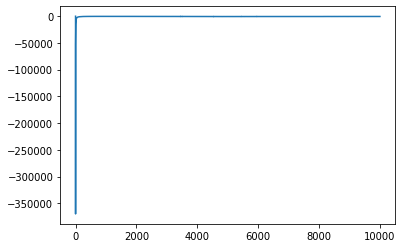

In [1541]:
plt.plot(-loss.numpy())
print('max ELBO: ', np.max(-loss.numpy()))

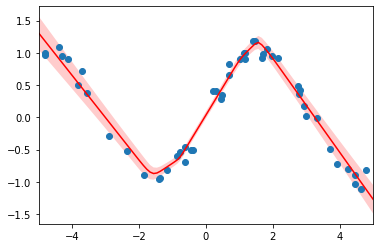

In [1542]:
n_grid = 100
n_samp = 100

x_grid = torch.cat((
    torch.linspace(-5,5,n_grid).reshape(-1,1),
    torch.ones(n_grid).reshape(-1,1)
),1)

y_samps=np.array([bnn(x_grid, sample=True).view(-1).detach().numpy() for _ in range(n_samp)])

sns.tsplot(y_samps, time=x_grid[:,0].numpy(),ci='sd',color='red')
plt.scatter(x[:,0].numpy(), y.numpy())

In [1543]:
bnn.sig2_alpha

tensor(25.0010)

In [1544]:
bnn.sig2_beta

tensor(0.7430)

In [1545]:
bnn.sig2_beta / (bnn.sig2_alpha - 1)

tensor(0.0310)

#### Expected weights 

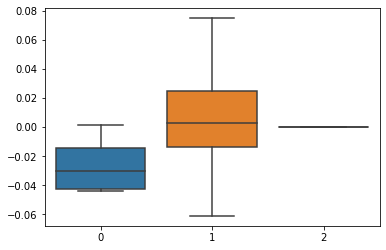

In [1546]:
# Expected weights leaving each input
E_w = bnn.fc1.expected_weights()

# Each boxplot is all weights FROM an input variable
#sns.boxplot(data=E_w) 
sns.boxplot(data=E_w, showfliers=False) 

0

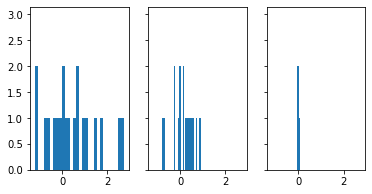

In [48]:
# Each histogram is all weights FROM an input variable
fig, ax = plt.subplots(1,3, figsize=(6,3), sharex=True, sharey=True)
ax[0].hist(E_w[:,0], bins=30) 
ax[1].hist(E_w[:,1], bins=30) 
ax[2].hist(E_w[:,2], bins=30) 
0

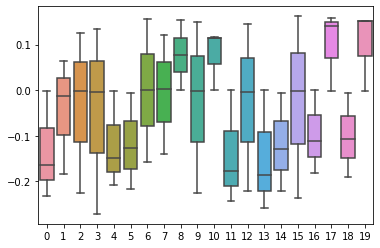

In [730]:
# Each boxplot is all weights TO a hidden unit
sns.boxplot(data=E_w.transpose(0,1)) 

#### Sampled weights

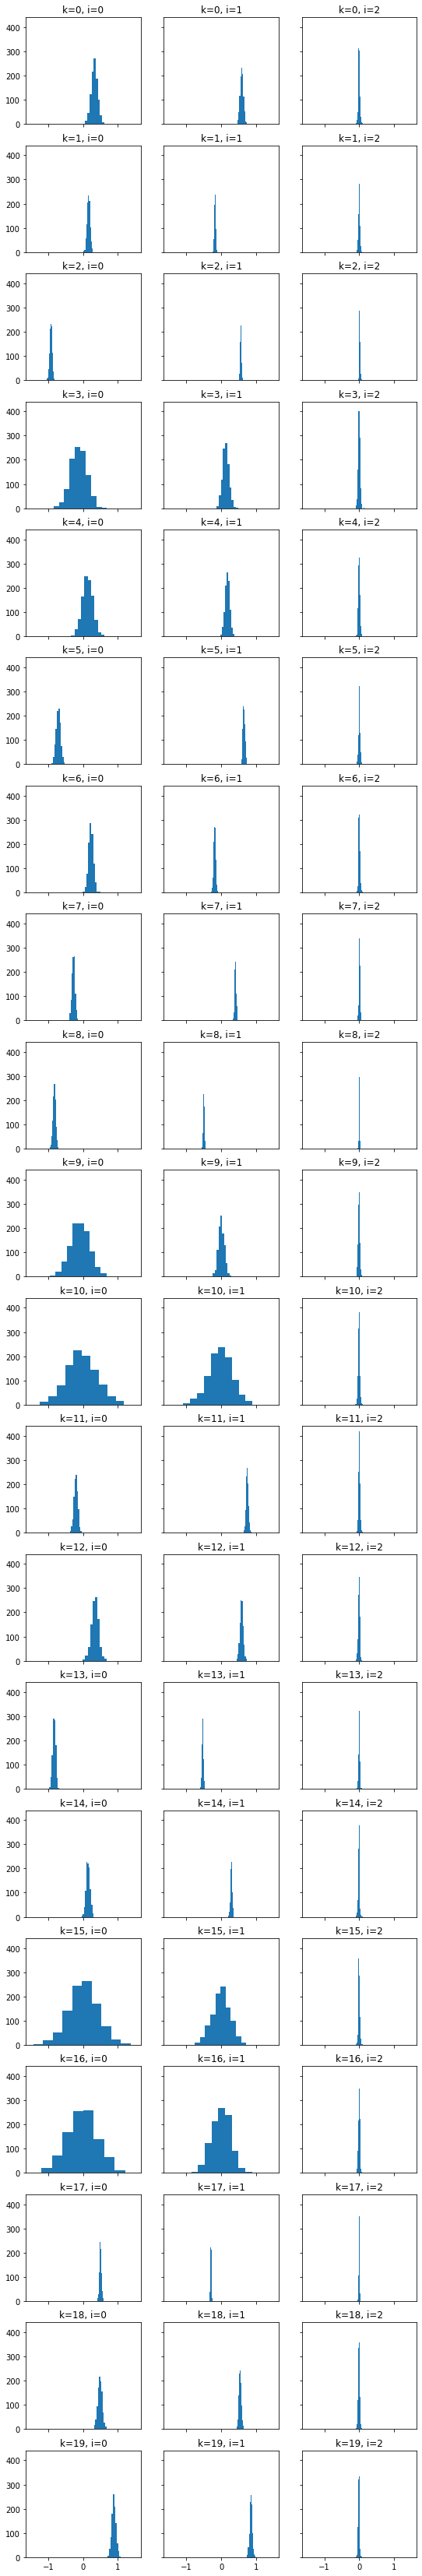

In [197]:
l = bnn.fc1
w = l.sample_weights(1000) # Each element of list is a hidden unit

units_show = l.dim_out

fig, ax = plt.subplots(units_show, l.dim_in, 
                       figsize=(3*l.dim_in,3*units_show),
                      sharex=True,sharey=True)

for k in range(units_show):
    for i in range(l.dim_in):
        ax[k,i].hist(w[k][:,i])
        ax[k,i].set_title('k=%d, i=%d'%(k,i))

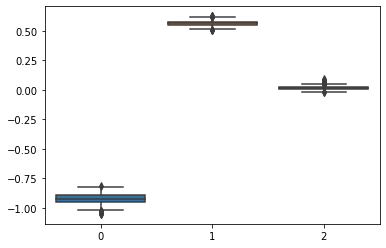

In [204]:
import seaborn as sns
# All weights going into a single hidden unit
sns.boxplot(data=w[2]) 

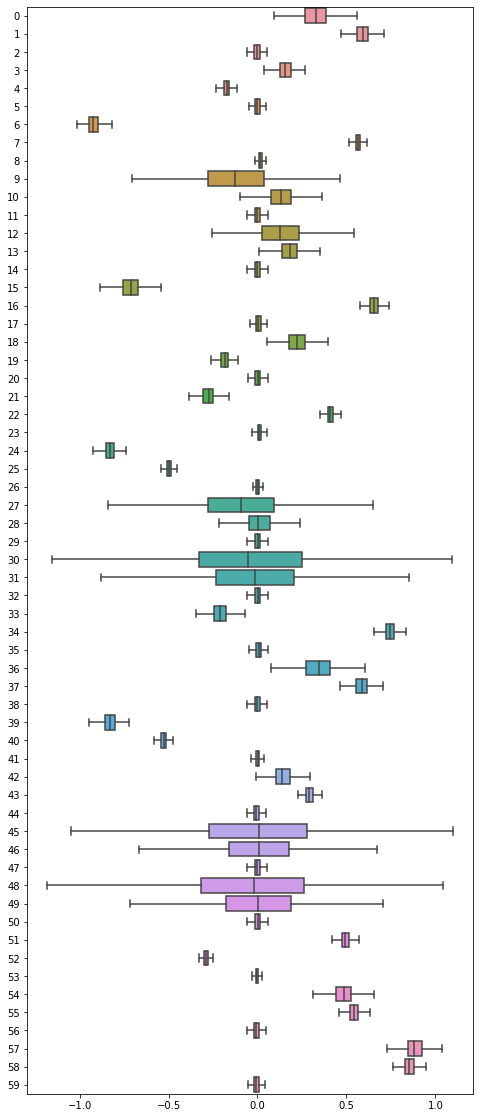

In [200]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,20))
sns.boxplot(data=np.hstack(w), orient='h', ax=ax, showfliers=False)
#ax.hlines(2.5,-25,25)
#ax.hlines(5.5,-25,25)

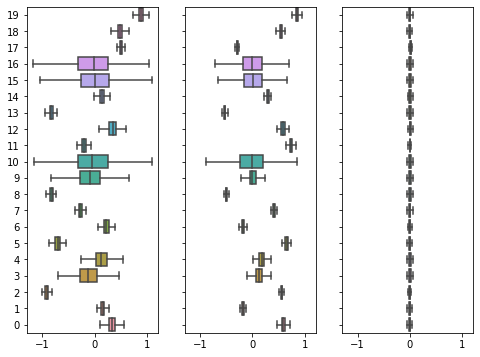

In [201]:
# Each column is all weights corresponding to a single input (first column is intercept)
fig, ax = plt.subplots(1,3,figsize=(8,6),sharex=True, sharey=True)

for i in range(3):
    sns.boxplot(data=np.hstack([ww[:,i].reshape(-1,1) for ww in w]), orient='h', ax=ax[i], showfliers=False)
    

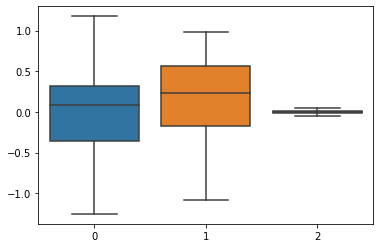

In [202]:
# Collapsed over all hidden units
sns.boxplot(data=np.vstack(w), showfliers=False)

## Data from `bkmr` package

In [2211]:
importlib.reload(layers)
importlib.reload(util)
importlib.reload(networks)

<module 'src.networks' from '/Users/beaucoker/Documents/Harvard_Biostat/summer 2019/src/networks.py'>

In [2212]:
x = torch.from_numpy(np.genfromtxt('bkmr/data/X.csv', delimiter=',')).float().reshape(-1,1) # Confounder
z = torch.from_numpy(np.genfromtxt('bkmr/data/Z.csv', delimiter=',')).float()
y = torch.from_numpy(np.genfromtxt('bkmr/data/y.csv', delimiter=',')).float().reshape(-1,1)

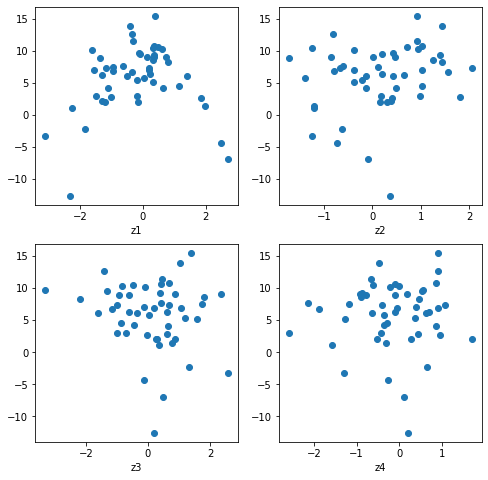

In [2213]:
fig, ax = plt.subplots(2,2, figsize=(8,8))

ax[0,0].set_xlabel('z1')
ax[0,0].scatter(z[:,0], y)

ax[0,1].set_xlabel('z2')
ax[0,1].scatter(z[:,1], y)

ax[1,0].set_xlabel('z3')
ax[1,0].scatter(z[:,2], y)

ax[1,1].set_xlabel('z4')
ax[1,1].scatter(z[:,3], y)

#### without confounder

In [1997]:
# Train BNN
torch.manual_seed(6)

bnn = networks.BNN(z.shape[1],y.shape[1], activation_type='relu', dim_hidden=20, n_layers=1, infer_noise=True, sig2_inv_alpha_prior=2., sig2_inv_beta_prior=.5)
optimizer = torch.optim.Adam(bnn.parameters(), lr=.001)


In [1998]:
torch.inverse(x.transpose(0,1) @ x) 

tensor([[0.0021]])

In [1999]:
torch.manual_seed(1)
bnn.reinit_parameters(z,y,n_reinit=10)
#bnn.loss(z,y)

loss = networks.train(bnn, optimizer, z, y, n_epochs=10000, n_warmup=9000, print_freq=1000)


Epoch[1000/10000], kl: 934.460144, elbo: -2643.088379
Epoch[2000/10000], kl: 870.586914, elbo: -2507.796631
Epoch[3000/10000], kl: 838.939575, elbo: -1896.086182
Epoch[4000/10000], kl: 826.872437, elbo: -1594.542480
Epoch[5000/10000], kl: 811.856323, elbo: -1511.109863
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[6000/10000], kl: 796.423950, elbo: -1538.053467
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[7000/10000], kl: 790.373962, elbo: -1319.267090
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
sa

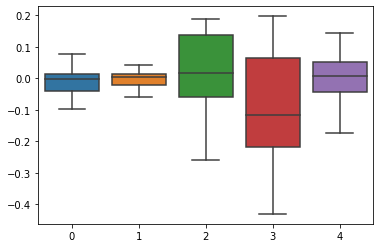

In [2000]:
# Expected weights leaving each input
E_w = bnn.fc1.expected_weights()

# Each boxplot is all weights FROM an input variable
#sns.boxplot(data=E_w) 
sns.boxplot(data=E_w, showfliers=False) 

#### with confounder

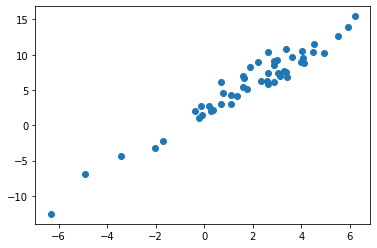

In [2207]:
plt.scatter(x,y)

In [2346]:
importlib.reload(layers)
importlib.reload(util)
importlib.reload(networks)

<module 'src.networks' from '/Users/beaucoker/Documents/Harvard_Biostat/summer 2019/src/networks.py'>

In [2347]:
# Train BNN
torch.manual_seed(6)

## without inferring noise
#bnn = networks.BNN(z.shape[1],y.shape[1], activation_type='relu', dim_hidden=20, n_layers=1, linear_term=True, linear_dim_in=x.shape[1], infer_noise=False, sig2_inv=2.)

## with inferrring noise
bnn = networks.BNN(z.shape[1],y.shape[1], activation_type='tanh', dim_hidden=20, n_layers=1, linear_term=True, linear_dim_in=x.shape[1], infer_noise=True, sig2_inv_alpha_prior=2., sig2_inv_beta_prior=1.)

optimizer = torch.optim.Adam(bnn.parameters(), lr=.001)


In [2348]:
torch.manual_seed(1)
bnn.reinit_parameters(z,y,n_reinit=10)
#bnn.loss(z,y)

loss = networks.train(bnn, optimizer, z, y, n_epochs=10000, x_linear=x, n_warmup=9000, print_freq=1000)


Epoch[1000/10000], kl: 1017.693909, elbo: -3130.044434
Epoch[2000/10000], kl: 933.228455, elbo: -2953.276855
Epoch[3000/10000], kl: 857.688660, elbo: -2808.148438
Epoch[4000/10000], kl: 785.441589, elbo: -2787.756592
Epoch[5000/10000], kl: 717.146667, elbo: -2696.796387
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...

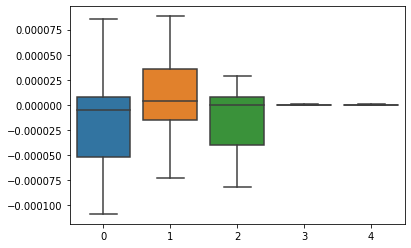

In [2349]:
# Expected weights leaving each input
E_w = bnn.fc1.expected_weights()

# Each boxplot is all weights FROM an input variable
#sns.boxplot(data=E_w) 
sns.boxplot(data=E_w, showfliers=False) 

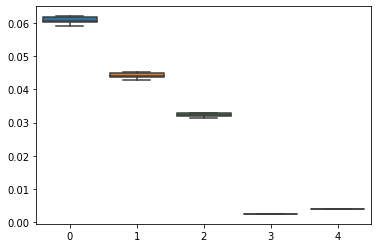

In [2350]:
# Expected weights leaving each input
V_w = bnn.fc1.variance_weights()

# Each boxplot is all weights FROM an input variable
#sns.boxplot(data=E_w) 
sns.boxplot(data=torch.sqrt(V_w), showfliers=False) 

[Text(0, 0, '1'), Text(0, 0, '2')]

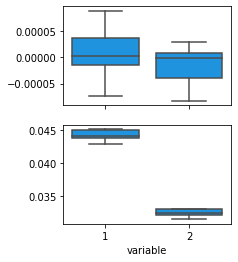

In [2363]:
# Formatted plot

fig, ax = plt.subplots(2,1,sharex=True,figsize=(3,4))
sns.boxplot(data=E_w[:,1:3], showfliers=False, ax=ax[0], color='#0099ff') 
#ax[0].set_ylabel('boxplot of weight mean')

sns.boxplot(data=torch.sqrt(V_w[:,1:3]), showfliers=False, ax=ax[1], color='#0099ff') 
#ax[1].set_ylabel('boxplot of weight std')
ax[1].set_xlabel('variable')

#ax[1].set_xticks(np.arange(4))

ax[1].set_xticklabels(range(1,3))

[Text(0, 0, '1'), Text(0, 0, '2'), Text(0, 0, '3'), Text(0, 0, '4')]

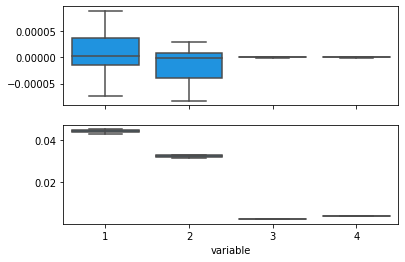

In [2351]:
# Formatted plot

fig, ax = plt.subplots(2,1,sharex=True)
sns.boxplot(data=E_w[:,1:], showfliers=False, ax=ax[0], color='#0099ff') 
#ax[0].set_ylabel('boxplot of weight mean')

sns.boxplot(data=torch.sqrt(V_w[:,1:]), showfliers=False, ax=ax[1], color='#0099ff') 
#ax[1].set_ylabel('boxplot of weight std')
ax[1].set_xlabel('variable')

#ax[1].set_xticks(np.arange(4))

ax[1].set_xticklabels(range(1,5))

In [2364]:
fig.savefig('example_inclusion.pdf')

In [2353]:
def zgrid(n, i, z):
    
    m = z.shape[1]
    out = torch.zeros((n, m))

    median = torch.median(z, dim=0)[0]

    out[:,i] = torch.linspace(z[:,i].min(),z[:,i].max(),n)
    out[:,0:i] = median[0:i]
    out[:,i+1:m] = median[i+1:m]
    
    return out

n = 100
i = 0

zpred = zgrid(n,i,z)
xpred = x.median() * torch.ones((n,1)).float()

In [2354]:
n_samp = 1000

ypred = torch.cat([bnn.forward(x=zpred, x_linear=None, sample=True) for _ in range(n_samp)], dim=1).detach().numpy()

//anaconda/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


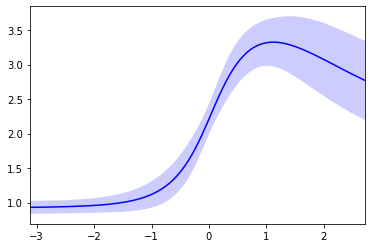

In [2355]:
sns.tsplot(ypred.T, time=zpred[:,i].numpy(),ci='sd',color='blue')

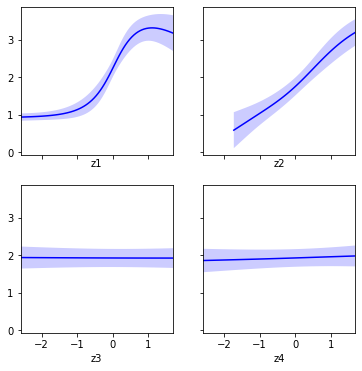

In [2356]:
fig, ax = plt.subplots(2,2, figsize=(6,6), sharex=True ,sharey=True)

ax_id = [(0,0),(0,1),(1,0),(1,1)]

for i in range(z.shape[1]):
    zpred = zgrid(n,i,z)
    xpred = x.median() * torch.ones((n,1)).float()

    ypred = torch.cat([bnn.forward(x=zpred, x_linear=None, sample=True) for _ in range(n_samp)], dim=1).detach().numpy()
    
    ax[ax_id[i]].set_xlabel('z'+str(i+1))
    sns.tsplot(ypred.T, time=zpred[:,i].numpy(),ci='sd',color='blue',ax = ax[ax_id[i]])
    
    

In [2357]:
fig.savefig('slices_bnn.pdf')

##  Scaling

In [2145]:
importlib.reload(layers)
importlib.reload(util)
importlib.reload(networks)
import time

In [2175]:
n = list(range(100,1100,100))

torch.manual_seed(132)

E_w_12 = np.zeros((len(n), 2*20))
E_w_34 = np.zeros((len(n), 2*20))

V_w_12 = np.zeros((len(n), 2*20))
V_w_34 = np.zeros((len(n), 2*20))

time_elapsed = np.zeros(len(n))

for i in range(len(n)):
    print('-------- n=%d ---------' %n[i])

    ## load data
    x = torch.from_numpy(np.genfromtxt('bkmr/data/X-n=%d.csv' % n[i], delimiter=',')).float().reshape(-1,1) # Confounder
    z = torch.from_numpy(np.genfromtxt('bkmr/data/Z-n=%d.csv' % n[i], delimiter=',')).float()
    y = torch.from_numpy(np.genfromtxt('bkmr/data/y-n=%d.csv' % n[i], delimiter=',')).float().reshape(-1,1)
    
    ## fit bnn
    # with inferrring noise
    bnn = networks.BNN(z.shape[1],y.shape[1], activation_type='tanh', dim_hidden=20, n_layers=1, linear_term=True, linear_dim_in=x.shape[1], infer_noise=True, sig2_inv_alpha_prior=2., sig2_inv_beta_prior=1.)

    optimizer = torch.optim.Adam(bnn.parameters(), lr=.0005)
    bnn.reinit_parameters(z,y,n_reinit=10)

    start_time = time.time()
    loss = networks.train(bnn, optimizer, z, y, n_epochs=10000, x_linear=x, n_warmup=9000, print_freq=1000)
    time_elapsed[i] = time.time() - start_time
    
    ## load best model
    checkpoint = torch.load('checkpoint.tar')
    bnn.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print('loading epoch ', checkpoint['epoch'])
    
    ## record
    E_w = bnn.fc1.expected_weights()
    V_w = bnn.fc1.variance_weights()
    
    E_w_12[i,:] = E_w[:,1:3].numpy().ravel()
    E_w_34[i,:] = E_w[:,3:5].numpy().ravel()
    
    V_w_12[i,:] = V_w[:,1:3].numpy().ravel()
    V_w_34[i,:] = V_w[:,3:5].numpy().ravel()
    
    

-------- n=100 ---------
Epoch[1000/10000], kl: 926.242676, elbo: -3832.421143
Epoch[2000/10000], kl: 887.474609, elbo: -3792.138184
Epoch[3000/10000], kl: 856.745972, elbo: -3768.923828
Epoch[4000/10000], kl: 828.508179, elbo: -3711.728027
Epoch[5000/10000], kl: 801.838196, elbo: -3713.221191
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
savin

saving...
saving...
saving...
saving...
Epoch[7000/10000], kl: 757.113098, elbo: -6313.663574
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving

saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[8000/10000], kl: 768.124268, elbo: -13310.100586
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
savin

saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[8000/10000], kl: 708.004150, elbo: -17266.015625
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
savin

saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...


saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[10000/10000], kl: 649.248962, elbo: -24041.664062
loading epoch  9991
-------- n=800 ---------
Epoch[1000/10000], kl: 973.827026, elbo: -33404.316406
Epoch[2000/10000], kl: 935.050293, elbo: -33233.511719
Epoch[3000/10000], kl: 900.047424, elbo: -33177.625000
Epoch[4000/10000], kl: 865.543640, elbo: -33058.054688
Epoch[5000/10000], kl: 831.146484, elbo: -33131.398438
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
savi

saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[9000/10000], kl: 689.658569, elbo: -36877.210938
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
savin

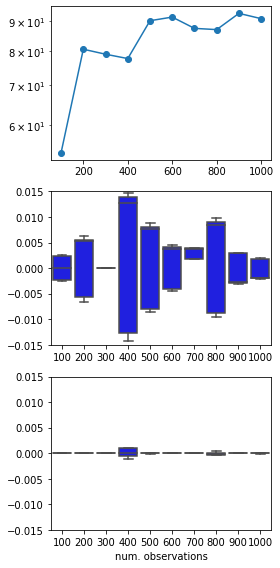

In [2198]:
fig,ax=plt.subplots(3,1, figsize=(4,8))
ax[0].semilogy(n, time_elapsed, '-o')

sns.boxplot(data=E_w_12.T, showfliers=False, ax=ax[1], color='blue') 
ax[1].set_ylim(-.015,.015)

sns.boxplot(data=E_w_34.T, showfliers=False, ax=ax[2], color='blue') 
ax[2].set_ylim(-.015,.015)
ax[2].set_xlabel('num. observations')


ax[1].set_xticklabels(n)
ax[2].set_xticklabels(n)

plt.tight_layout()

In [2199]:
fig.savefig('scaling_bnn.pdf')

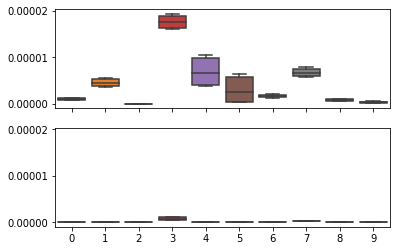

In [2177]:
# Formatted plot
fig, ax = plt.subplots(2,1,sharex=True, sharey=True)

sns.boxplot(data=V_w_12.T, showfliers=False, ax=ax[0]) 

sns.boxplot(data=V_w_34.T, showfliers=False, ax=ax[1])

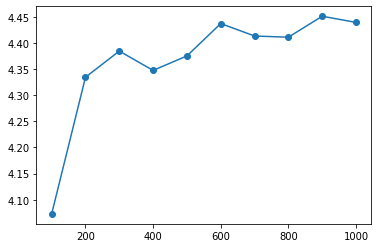

In [2133]:
plt.plot(n, np.log(time_elapsed), '-o')

## Simulation study from lasso paper

In [2]:
import seaborn as sns
importlib.reload(layers)
importlib.reload(util)
importlib.reload(networks)

<module 'src.networks' from '/Users/beaucoker/Documents/Harvard_Biostat/summer 2019/src/networks.py'>

In [3]:
f_true = lambda X:   np.tanh( X[:,0] +  2*X[:,1] -  3*X[:,2] + 2*X[:,3]) + \
                   2*np.tanh( X[:,0] -    X[:,4] +  2*X[:,5]           ) + \
                     np.tanh(-X[:,1] -    X[:,2] -    X[:,5]           ) + \
                     np.tanh( X[:,4] - .5*X[:,2] + .5*X[:,5]           )

def run_sim(n_obs, p_excess, dim_hidden):
    
    p_true = 6
    sigma_y = 1.0 # What should this be?

    # simulate dataset
    x = np.random.uniform(0,1,(n_obs,p_excess+p_true))
    y = f_true(x) + sigma_y*np.random.normal(0,1,n_obs)

    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).float().reshape(-1,1)

    # fit network
    bnn = networks.BNN(x.shape[1],y.shape[1], activation_type='tanh', dim_hidden=dim_hidden, n_layers=1, sigma_y=sigma_y)
    optimizer = torch.optim.Adam(bnn.parameters(), lr=.001)

    bnn.reinit_parameters(x,y,n_reinit=10)
    loss = networks.train(bnn, optimizer, x, y, n_epochs=10000, print_freq=1000)

    # excess loss
    n_eval = 1000

    x_eval = np.random.uniform(0,1,(n_eval,p_excess+p_true))
    y_eval = f_true(x_eval) + sigma_y*np.random.normal(0,1,n_eval)

    x_eval = torch.from_numpy(x_eval).float()
    y_eval = torch.from_numpy(y_eval).float().reshape(-1,1)

    ypred_eval = bnn(x_eval,sample=False)

    excess_loss = torch.mean((y_eval-ypred_eval)**2).item()


    # weight on excess variables
    E_w = bnn.fc1.expected_weights()

    w_norm = np.linalg.norm(E_w.numpy(),2,axis=0)

    w_norm_avg_true = np.mean(w_norm[1:p_true+1])
    w_norm_avg_excess = np.mean(w_norm[p_true:])

    return excess_loss, w_norm_avg_true, w_norm_avg_excess



In [86]:
#excess_loss, w_norm_avg_true, w_norm_avg_excess = run_sim(n_obs=50, p_excess=4, dim_hidden=4)

Epoch[1000/10000], kl: 151.545181, elbo: -4.435925
Epoch[2000/10000], kl: 123.789749, elbo: -3.781062
Epoch[3000/10000], kl: 102.250694, elbo: -3.444614
Epoch[4000/10000], kl: 86.697151, elbo: -3.714055
Epoch[5000/10000], kl: 76.368340, elbo: -3.421320
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[6000/10000], kl: 69.802933, elbo: -2.783757
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[7000/10000], kl: 64.981140, elbo: -2.800229
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[8000/10000], kl: 61.242588, elbo: -2.640998
saving...
saving...
saving...
saving...
saving...
Epoch[9000/10000], kl: 58.636055, elbo: -2.486136
saving...
saving...
saving...
saving...
saving.

Varying number of covariates

In [7]:
p_excess_list = [2,4,6,8]
n_rep = 10
res = np.zeros((len(p_excess_list)*n_rep, 5))

n_obs=100
dim_hidden=4

for i, p_excess in enumerate(p_excess_list):
    for rep in range(n_rep):
        res[i+rep,0] = p_excess
        res[i+rep,1] = rep
        res[i+rep,2:] = run_sim(n_obs, p_excess, dim_hidden)

Epoch[1000/10000], kl: 138.539139, elbo: -3.041784
Epoch[2000/10000], kl: 113.031105, elbo: -2.722775
Epoch[3000/10000], kl: 95.719955, elbo: -2.486062
Epoch[4000/10000], kl: 83.129425, elbo: -2.325244
Epoch[5000/10000], kl: 73.372574, elbo: -2.298491
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[6000/10000], kl: 66.251389, elbo: -2.238830
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[7000/10000], kl: 60.960201, elbo: -2.214104
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[8000/10000], kl: 57.289429, elbo: -2.144374
saving...
saving...
saving...
saving...
saving...
Epoch[9000/10000], kl: 54.548424, elbo: -2.109628
saving...
saving...
saving...
saving...
Epoch[10000/10000], kl: 52.383945, elbo: -2.035682
Epoch[1000/10000], kl: 126.294449, elbo: -3.005727
Epoch[2000/10000], kl: 102

Epoch[5000/10000], kl: 78.946846, elbo: -2.243394
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[6000/10000], kl: 72.233582, elbo: -2.204227
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[7000/10000], kl: 67.619324, elbo: -2.286504
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[8000/10000], kl: 64.140419, elbo: -2.141700
saving...
saving...
saving...
saving...
Epoch[9000/10000], kl: 61.656342, elbo: -2.035454
saving...
saving...
saving...
saving...
Epoch[10000/10000], kl: 60.022476, elbo: -2.035644
Epoch[1000/10000], kl: 155.093323, elbo: -3.221934
Epoch[2000/10000], kl: 128.981705, elbo: -2.969060
Epoch[3000/10000], kl: 109.388344, elbo: -2.604001
Epoch[4000/10000], kl: 96.046913, elbo: -2.525553
Epoch[5000/10000], kl: 88.

saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[7000/10000], kl: 81.610901, elbo: -2.263052
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[8000/10000], kl: 78.551109, elbo: -2.207552
saving...
Epoch[9000/10000], kl: 76.064354, elbo: -2.211542
saving...
saving...
Epoch[10000/10000], kl: 74.063408, elbo: -2.187769
Epoch[1000/10000], kl: 179.697388, elbo: -3.321225
Epoch[2000/10000], kl: 147.645615, elbo: -2.910452
Epoch[3000/10000], kl: 123.097771, elbo: -2.668074
Epoch[4000/10000], kl: 106.333916, elbo: -2.574429
Epoch[5000/10000], kl: 95.804588, elbo: -2.618704
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[6000/10000], kl: 89.231636, elbo: -2.396472
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[7000/10000], kl: 84.430542, elbo: -2.339646
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch

saving...
saving...
Epoch[10000/10000], kl: 84.646225, elbo: -2.345070
Epoch[1000/10000], kl: 196.151535, elbo: -3.541638
Epoch[2000/10000], kl: 160.489258, elbo: -3.154981
Epoch[3000/10000], kl: 135.323349, elbo: -2.795971
Epoch[4000/10000], kl: 117.700073, elbo: -2.784315
Epoch[5000/10000], kl: 106.106651, elbo: -2.499343
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[6000/10000], kl: 99.981476, elbo: -2.559101
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[7000/10000], kl: 95.773666, elbo: -2.605481
saving...
saving...
Epoch[8000/10000], kl: 92.549316, elbo: -2.395993
saving...
saving...
saving...
saving...
saving...
Epoch[9000/10000], kl: 89.987267, elbo: -2.445251
saving...
saving...
Epoch[10000/10000], kl: 87.956848, elbo: -2.469738
Epoch[1000/10000], kl: 186.866425, elbo: -3.546988
Epoch[2000/10000], kl: 151.480209, elbo: -2.912503
Epoch[3000/10000], kl: 125.135483, elbo: -2.663289


In [10]:
res

array([[ 2.        ,  0.        ,  2.95725393,  1.04632366,  0.85353297],
       [ 4.        ,  0.        ,  2.45454526,  1.19950306,  0.74256742],
       [ 6.        ,  0.        ,  3.38909626,  1.06692731,  0.60747164],
       [ 8.        ,  0.        ,  4.43800068,  1.50013065,  0.56946629],
       [ 8.        ,  1.        , 21.61143875,  2.2930367 ,  0.85307384],
       [ 8.        ,  2.        ,  2.70778584,  0.60856217,  0.19661456],
       [ 8.        ,  3.        ,  4.53236914,  1.05002928,  0.30818483],
       [ 8.        ,  4.        ,  2.41129661,  0.91737622,  0.25913876],
       [ 8.        ,  5.        ,  6.72388506,  0.68843031,  0.29686442],
       [ 8.        ,  6.        ,  5.4429493 ,  1.27431118,  0.63025653],
       [ 8.        ,  7.        ,  3.69881058,  0.64691168,  0.28107393],
       [ 8.        ,  8.        ,  4.03643274,  0.91830635,  0.33771408],
       [ 8.        ,  9.        ,  6.62443781,  1.4779247 ,  0.43005869],
       [ 0.        ,  0.        ,  0. 

Text(0.5, 0, 'p_excess')

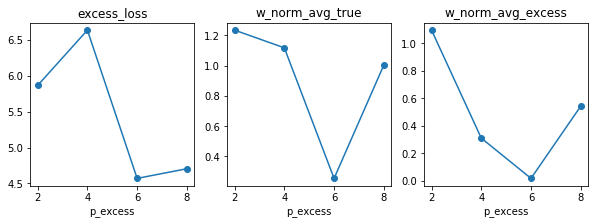

In [99]:
fig, ax = plt.subplots(1,3, figsize=(10,3), sharex=True)

ax[0].plot(p_excess_list, res[:,0], '-o')
ax[0].set_title('excess_loss')
ax[0].set_xlabel('p_excess')

ax[1].plot(p_excess_list, res[:,1], '-o')
ax[1].set_title('w_norm_avg_true')
ax[1].set_xlabel('p_excess')

ax[2].plot(p_excess_list, res[:,2], '-o')
ax[2].set_title('w_norm_avg_excess')
ax[2].set_xlabel('p_excess')

In [6]:
res.shape

(4, 5)

## Simulated Boston data

In [2371]:
importlib.reload(layers)
importlib.reload(util)
importlib.reload(networks)

<module 'src.networks' from '/Users/beaucoker/Documents/Harvard_Biostat/summer 2019/src/networks.py'>

In [2369]:
def plogis(q, mu, s):
    return 0.5 + 0.5*np.tanh((q-mu)/(2*s))

def HFun3(z):
    return 4*plogis(1/4*(z[:,0] + z[:,1] + 1/2*z[:,0]*z[:,1]), 0, 0.3)

HFun3(np.array([[1,2,0]]))

array([3.86221922])

In [2376]:
i

0

In [2377]:
n_datasets = 10

torch.manual_seed(132)

time_elapsed = np.zeros(n_datasets)

E_w_list = list()
V_w_list = list()

for i in range(n_datasets):
    print('-------- i=%d ---------' %i)

    ## load data
    x = torch.from_numpy(np.genfromtxt('bkmr/data/real-X-i=%d.csv' % (i+1), delimiter=',')).float().reshape(-1,1) # Confounder
    z = torch.from_numpy(np.genfromtxt('bkmr/data/real-Z-i=%d.csv' % (i+1), delimiter=',')).float()
    y = torch.from_numpy(np.genfromtxt('bkmr/data/real-y-i=%d.csv' % (i+1), delimiter=',')).float().reshape(-1,1)
    
    ## fit bnn
    # with inferrring noise
    bnn = networks.BNN(z.shape[1],y.shape[1], activation_type='tanh', dim_hidden=20, n_layers=1, linear_term=True, linear_dim_in=x.shape[1], infer_noise=True, sig2_inv_alpha_prior=2., sig2_inv_beta_prior=1.)

    optimizer = torch.optim.Adam(bnn.parameters(), lr=.0005)
    bnn.reinit_parameters(z,y,n_reinit=10)

    start_time = time.time()
    loss = networks.train(bnn, optimizer, z, y, n_epochs=10000, x_linear=x, n_warmup=9000, print_freq=1000)
    time_elapsed[i] = time.time() - start_time
    
    ## load best model
    checkpoint = torch.load('checkpoint.tar')
    bnn.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print('loading epoch ', checkpoint['epoch'])
    
    ## record
    E_w_list.append(bnn.fc1.expected_weights())
    V_w_list.append(bnn.fc1.variance_weights())
    
    

-------- i=0 ---------
Epoch[1000/10000], kl: 2003.555420, elbo: -6807.099609
Epoch[2000/10000], kl: 1909.198242, elbo: -5089.083984
Epoch[3000/10000], kl: 1822.812378, elbo: -4956.979980
Epoch[4000/10000], kl: 1739.719116, elbo: -4867.865234
Epoch[5000/10000], kl: 1658.114868, elbo: -4725.993164
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
sa

saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[6000/10000], kl: 1574.077148, elbo: -5335.186523
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
savin

saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[7000/10000], kl: 1486.405029, elbo: -5419.252930
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
savin

saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[8000/10000], kl: 1406.704956, elbo: -5007.395996
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
savin

saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[9000/10000], kl: 1339.786621, elbo: -5588.032227
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
savin

saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[10000/10000], kl: 1245.352295, elbo: -7277.661133
loading epoch  9986
-------- i=6 ---------
E

saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...


saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[6000/10000], kl: 1567.200439, elbo

saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[6000/10000], kl: 1563.314941, elbo: -5339.214844
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
savin

In [2380]:
torch.cat(E_w_list).shape

torch.Size([200, 14])

[Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10'),
 Text(0, 0, '11'),
 Text(0, 0, '12'),
 Text(0, 0, '13')]

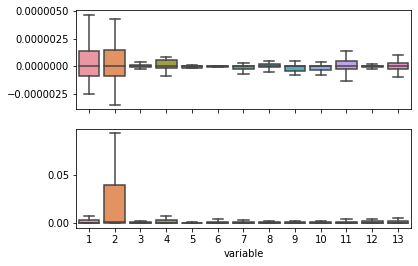

In [2388]:
fig, ax = plt.subplots(2,1, sharex=True)

#ax[0].set_title('Each boxplot is all units FROM the input')
#ax[0].set_xlabel('variable')
sns.boxplot(data=torch.cat(E_w_list)[:,1:], showfliers=False, ax=ax[0]) 

ax[1].set_xlabel('variable')
sns.boxplot(data=torch.sqrt(torch.cat(V_w_list)[:,1:]), showfliers=False, ax=ax[1]) 

ax[1].set_xticklabels(range(1,14))

In [2389]:
fig.savefig('bnn_realistic.pdf')

In [940]:
n_datasets = 10
n_epochs = 10000
response = '1'

E_w_list = list()
loss = np.zeros((n_epochs, n_datasets))

for i in range(n_datasets):
    
    x, y = util.simulate_boston_dataset(n_samp=200, sig_y=.01, response=response, seed=i)
    
    # Initialize model
    torch.manual_seed(i+1)
    bnn = networks.BNN(x.shape[1],y.shape[1], activation_type='relu', dim_hidden=20, n_layers=1, sigma_y=.01)
    optimizer = torch.optim.Adam(bnn.parameters(), lr=.001)

    # Train model
    #torch.manual_seed(0)
    bnn.reinit_parameters(x,y,n_reinit=10)
    loss[:,i] = networks.train(bnn, optimizer, x, y, n_epochs=n_epochs, print_freq=1000)
    
    # Load best model
    checkpoint = torch.load('checkpoint.tar')
    bnn.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Record expected weights of first layer
    E_w_list.append(bnn.fc1.expected_weights())
    

Epoch[1000/10000], kl: 3931.808350, elbo: -70.570511
Epoch[2000/10000], kl: 2822.071533, elbo: -47.184326
Epoch[3000/10000], kl: 2486.008545, elbo: -15.845807
Epoch[4000/10000], kl: 2318.164062, elbo: -10.112556
Epoch[5000/10000], kl: 2200.997559, elbo: -8.523883
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[6000/10000], kl: 2109.483154, elbo: -9.202014
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[7000/10000], kl: 2034.898193, elbo: -7.544557
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[8000/10000], kl: 1970.960083, elbo: -7.715562
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[9000/10000], kl: 1915.669556, elbo: -9.664751
saving...
saving...
saving...
saving...
saving...
saving...
saving..

saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[6000/10000], kl: 2482.732178, elbo: -28.203850
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[7000/10000], kl: 2369.445068, elbo: -18.319675
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[8000/10000], kl: 2289.572021, elbo: -15.549397
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[9000/10000], kl: 2229.972656, elbo: -11.801498
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[10000/10000], kl: 2188.500977, e

Epoch[5000/10000], kl: 2107.390625, elbo: -27.496834
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[6000/10000], kl: 1952.554688, elbo: -14.353388
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
savi

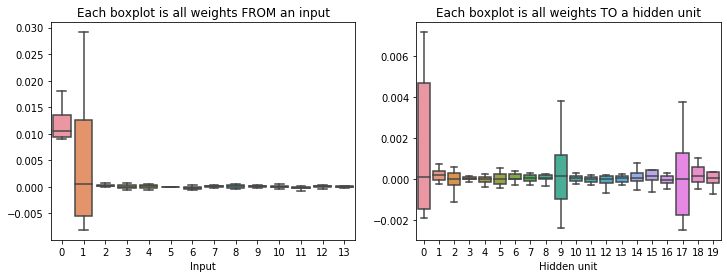

In [941]:
# Each boxplot is all weights FROM an input variable for a SINGLE model (i.e. one dataset)
fix, ax = plt.subplots(1,2,figsize=(12,4))
dataset_idx = 0

ax[0].set_title('Each boxplot is all weights FROM an input')
ax[0].set_xlabel('Input')
sns.boxplot(data=E_w_list[dataset_idx], showfliers=False, ax=ax[0]) 

ax[1].set_title('Each boxplot is all weights TO a hidden unit')
ax[1].set_xlabel('Hidden unit')
sns.boxplot(data=E_w_list[dataset_idx].transpose(0,1), showfliers=False, ax=ax[1]) 

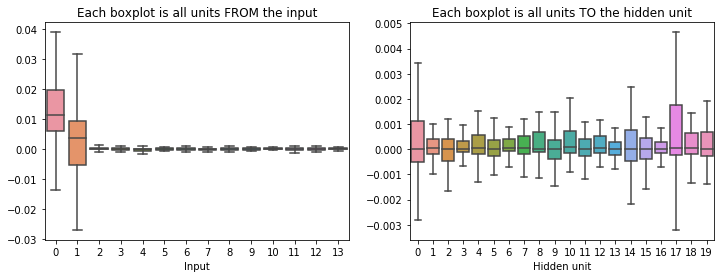

In [942]:
fix, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].set_title('Each boxplot is all units FROM the input')
ax[0].set_xlabel('Input')
sns.boxplot(data=torch.cat(E_w_list), showfliers=False, ax=ax[0]) 

ax[1].set_title('Each boxplot is all units TO the hidden unit')
ax[1].set_xlabel('Hidden unit')
sns.boxplot(data=torch.cat(E_w_list,1).transpose(0,1), showfliers=False, ax=ax[1]) 

In [943]:
n_datasets = 10
n_epochs = 10000
response = '2'

E_w_list = list()
loss = np.zeros((n_epochs, n_datasets))

for i in range(n_datasets):
    
    x, y = util.simulate_boston_dataset(n_samp=200, sig_y=.01, response=response, seed=i)
    
    # Initialize model
    torch.manual_seed(i+1)
    bnn = networks.BNN(x.shape[1],y.shape[1], activation_type='relu', dim_hidden=20, n_layers=1, sigma_y=.01)
    optimizer = torch.optim.Adam(bnn.parameters(), lr=.001)

    # Train model
    #torch.manual_seed(0)
    bnn.reinit_parameters(x,y,n_reinit=10)
    loss[:,i] = networks.train(bnn, optimizer, x, y, n_epochs=n_epochs, print_freq=1000)
    
    # Load best model
    checkpoint = torch.load('checkpoint.tar')
    bnn.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Record expected weights of first layer
    E_w_list.append(bnn.fc1.expected_weights())

Epoch[1000/10000], kl: 42282.917969, elbo: -82636.234375
Epoch[2000/10000], kl: 19733.093750, elbo: -13788.883789
Epoch[3000/10000], kl: 10998.276367, elbo: -10478.925781
Epoch[4000/10000], kl: 7574.416016, elbo: -6185.517090
Epoch[5000/10000], kl: 6146.058594, elbo: -5130.394531
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[6000/10000], kl: 5401.834473, elbo: -3702.639404
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[7000/10000], kl: 4951.105469, elbo: -3162.783447
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...

saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[8000/10000], kl: 3111.940918, elbo: -6884.953613
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[9000/10000], kl: 3056.079102, elbo: -4946.776855
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[10000/10000], kl: 2968.2

saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[6000/10000], kl: 2631.145996, elbo: -5615.653320
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[7000/10000], kl: 2621.669434, elbo: -3838.358398
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...


saving...
Epoch[9000/10000], kl: 3086.526367, elbo: -1415.528198
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[10000/10000], kl: 3074.306396, elbo: -962.540161


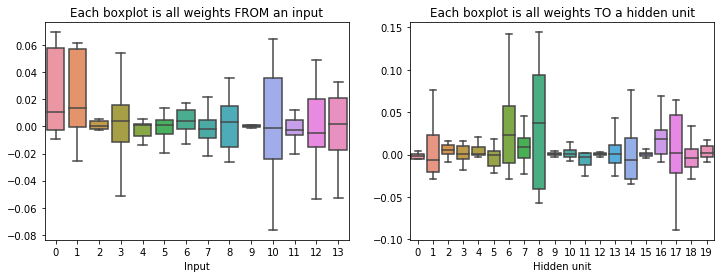

In [944]:
# Each boxplot is all weights FROM an input variable for a SINGLE model (i.e. one dataset)
fix, ax = plt.subplots(1,2,figsize=(12,4))
dataset_idx = 0

ax[0].set_title('Each boxplot is all weights FROM an input')
ax[0].set_xlabel('Input')
sns.boxplot(data=E_w_list[dataset_idx], showfliers=False, ax=ax[0]) 

ax[1].set_title('Each boxplot is all weights TO a hidden unit')
ax[1].set_xlabel('Hidden unit')
sns.boxplot(data=E_w_list[dataset_idx].transpose(0,1), showfliers=False, ax=ax[1]) 

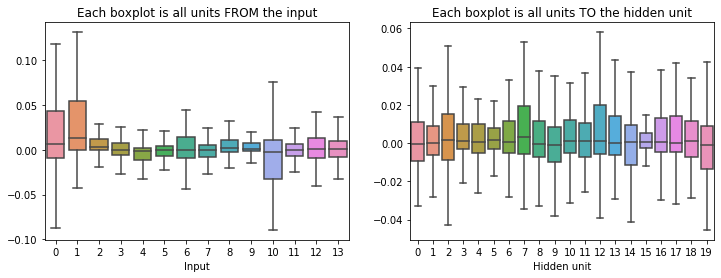

In [945]:
fix, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].set_title('Each boxplot is all units FROM the input')
ax[0].set_xlabel('Input')
sns.boxplot(data=torch.cat(E_w_list), showfliers=False, ax=ax[0]) 

ax[1].set_title('Each boxplot is all units TO the hidden unit')
ax[1].set_xlabel('Hidden unit')
sns.boxplot(data=torch.cat(E_w_list,1).transpose(0,1), showfliers=False, ax=ax[1]) 

In [946]:
n_datasets = 10
n_epochs = 10000
response = '3'

E_w_list = list()
loss = np.zeros((n_epochs, n_datasets))

for i in range(n_datasets):
    
    x, y = util.simulate_boston_dataset(n_samp=200, sig_y=.01, response=response, seed=i)
    
    # Initialize model
    torch.manual_seed(i+1)
    bnn = networks.BNN(x.shape[1],y.shape[1], activation_type='relu', dim_hidden=20, n_layers=1, sigma_y=.01)
    optimizer = torch.optim.Adam(bnn.parameters(), lr=.001)

    # Train model
    #torch.manual_seed(0)
    bnn.reinit_parameters(x,y,n_reinit=10)
    loss[:,i] = networks.train(bnn, optimizer, x, y, n_epochs=n_epochs, print_freq=1000)
    
    # Load best model
    checkpoint = torch.load('checkpoint.tar')
    bnn.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Record expected weights of first layer
    E_w_list.append(bnn.fc1.expected_weights())

Epoch[1000/10000], kl: 3975.549805, elbo: -326.861908
Epoch[2000/10000], kl: 2974.874268, elbo: -204.296341
Epoch[3000/10000], kl: 2710.807861, elbo: -88.339836
Epoch[4000/10000], kl: 2631.779297, elbo: -69.452843
Epoch[5000/10000], kl: 2575.451660, elbo: -64.075020
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[6000/10000], kl: 2531.270264, elbo: -74.379356
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[7000/10000], kl: 2496.944580, elbo: -50.760986
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[8000/10000], kl: 2473.485840, elbo: -54.288437
saving...
savi

saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[6000/10000], kl: 2828.971436, elbo: -275.159485
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[7000/10000], kl: 2686.380615, elbo: -252.445618
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[8000/10000], kl: 2594.859863, elbo: -251.140747
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving..

saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
Epoch[6000/10000], kl: 2689.187256, elbo: -232.979767
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving...
saving

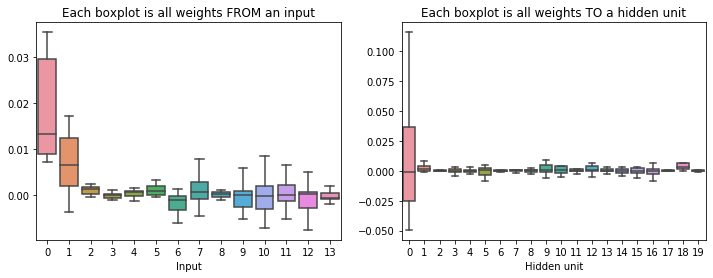

In [947]:
# Each boxplot is all weights FROM an input variable for a SINGLE model (i.e. one dataset)
fix, ax = plt.subplots(1,2,figsize=(12,4))
dataset_idx = 0

ax[0].set_title('Each boxplot is all weights FROM an input')
ax[0].set_xlabel('Input')
sns.boxplot(data=E_w_list[dataset_idx], showfliers=False, ax=ax[0]) 

ax[1].set_title('Each boxplot is all weights TO a hidden unit')
ax[1].set_xlabel('Hidden unit')
sns.boxplot(data=E_w_list[dataset_idx].transpose(0,1), showfliers=False, ax=ax[1]) 

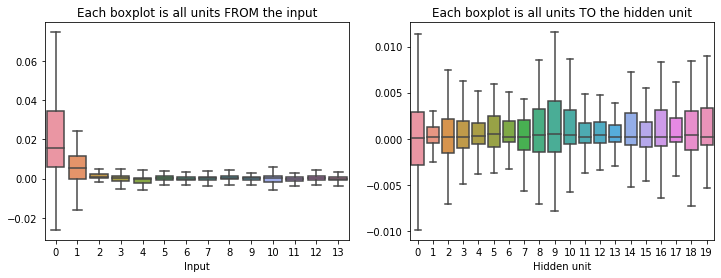

In [948]:
fix, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].set_title('Each boxplot is all units FROM the input')
ax[0].set_xlabel('Input')
sns.boxplot(data=torch.cat(E_w_list), showfliers=False, ax=ax[0]) 

ax[1].set_title('Each boxplot is all units TO the hidden unit')
ax[1].set_xlabel('Hidden unit')
sns.boxplot(data=torch.cat(E_w_list,1).transpose(0,1), showfliers=False, ax=ax[1]) 

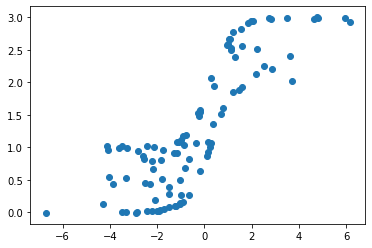

In [935]:
x, y = util.simulate_boston_dataset(n_samp=100, sig_y=.01, response=response, seed=i)
    
plt.scatter(x[:,0],y)

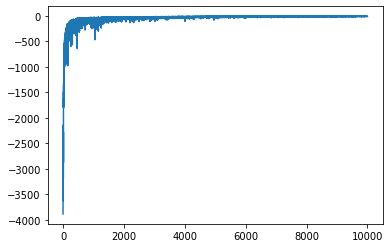

In [785]:
plt.plot(-loss)

In [951]:
bnn.parameters()

<generator object Module.parameters at 0x14ad04b88>

## Compare to actual hs-bnn

In [420]:
importlib.reload(layers)
importlib.reload(util)
importlib.reload(networks)

<module 'src.networks' from '/Users/beaucoker/Documents/Harvard_Biostat/summer 2019/src/networks.py'>

In [421]:
import numpy.random as npr
def regression_data(seed, data_count=500):
    """
    Generate data from a noisy sine wave.
    :param seed: random number seed
    :param data_count: number of data points.
    :return:
    """
    np.random.seed(seed)
    noise_var = 0.1

    x = np.linspace(-4, 4, data_count)
    y = 1*np.sin(x) + np.sqrt(noise_var)*npr.randn(data_count)

    train_count = int (0.2 * data_count)
    idx = npr.permutation(range(data_count))
    x_train = x[idx[:train_count], np.newaxis ]
    x_test = x[ idx[train_count:], np.newaxis ]
    y_train = y[ idx[:train_count] ]
    y_test = y[ idx[train_count:] ]

    mu = np.mean(x_train, 0)
    std = np.std(x_train, 0)
    x_train = (x_train - mu) / std
    x_test = (x_test - mu) / std
    mu = np.mean(y_train, 0)
    std = np.std(y_train, 0)
    y_train = (y_train - mu) / std
    train_stats = dict()
    train_stats['mu'] = mu
    train_stats['sigma'] = std

    return x_train, y_train, x_test, y_test, train_stats

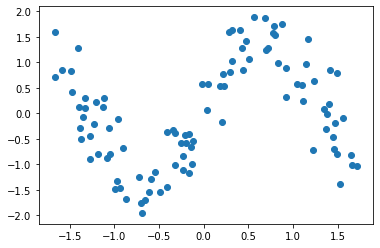

In [422]:
x_train, y_train, x_test, y_test, train_stats = regression_data(0)
plt.scatter(x_train, y_train)

In [423]:
# Train BNN
varbnn = networks.VariationalBNN(1,1,.001, activation_type='tanh', dim_hidden=10, n_layers=1, sigma_y=1.0)
elbo = varbnn.train(x=torch.from_numpy(x_train).float(),
                    y=torch.from_numpy(y_train).float().reshape(-1,1),
                    n_epochs=10000, print_freq=1000)



Epoch[1000/10000], log_prob: -1.234347, kl: 1.313350, elbo: -2.547697
Epoch[2000/10000], log_prob: -1.083735, kl: 1.137700, elbo: -2.221436
Epoch[3000/10000], log_prob: -1.138340, kl: 0.975588, elbo: -2.113928
Epoch[4000/10000], log_prob: -1.048851, kl: 0.841299, elbo: -1.890150
Epoch[5000/10000], log_prob: -1.040604, kl: 0.754866, elbo: -1.795470
Epoch[6000/10000], log_prob: -1.104725, kl: 0.714680, elbo: -1.819405
Epoch[7000/10000], log_prob: -1.048160, kl: 0.687688, elbo: -1.735847
Epoch[8000/10000], log_prob: -1.106289, kl: 0.661339, elbo: -1.767628
Epoch[9000/10000], log_prob: -1.046710, kl: 0.636441, elbo: -1.683151
Epoch[10000/10000], log_prob: -1.033032, kl: 0.613216, elbo: -1.646248


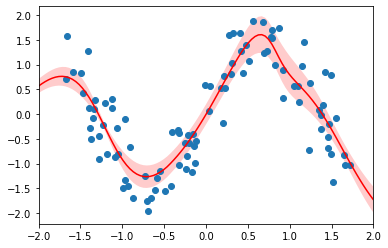

In [424]:
n_grid = 100
n_samp = 100

x_grid = torch.linspace(-2,2,n_grid).reshape(-1,1)

y_samps=np.array([varbnn.bnn(x_grid, sample=True).view(-1).detach().numpy() for _ in range(n_samp)])

sns.tsplot(y_samps, time=x_grid[:,0].numpy(),ci='sd',color='red')
plt.scatter(x_train, y_train)


In [425]:
l = varbnn.bnn.fc1
w = l.sample_weights(1000) # Each element of list is a hidden unit

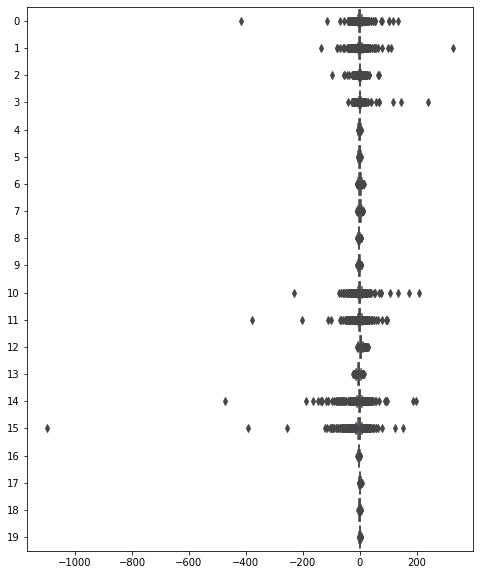

In [440]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,10))
sns.boxplot(data=np.hstack(w), orient='h', ax=ax)

(1000, 20)

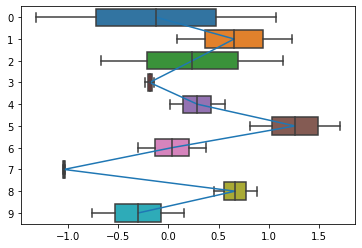

In [587]:
arr = np.random.normal(0,1,(2,10))
sns.boxplot(data=arr, orient='h')

plt.plot(np.median(arr,0),np.arange(10))

In [586]:
np.median(arr,0)

array([ 1.35371016,  1.41710452,  0.13174486,  0.86939873,  0.23175386,
       -0.40655528,  1.19779418, -0.91270884,  0.51265272, -0.37682691])

## Some plots from bkmr

In [1809]:
delta = np.genfromtxt('bkmr/data/del.csv', delimiter=',')


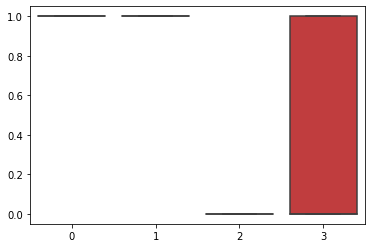

In [1810]:
sns.boxplot(data=delta, showfliers=False) 

[Text(0, 0, '1'), Text(0, 0, '2'), Text(0, 0, '3'), Text(0, 0, '4')]

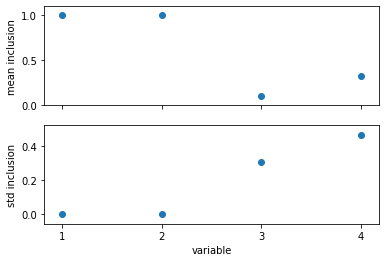

In [1842]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].scatter(np.arange(4), np.mean(delta, axis=0))
ax[0].set_ylim(0,1.1)
ax[0].set_ylabel('mean inclusion')

ax[1].scatter(np.arange(4), np.std(delta, axis=0))
ax[1].set_ylabel('std inclusion')
ax[1].set_xlabel('variable')

ax[1].set_xticks(np.arange(4))

ax[1].set_xticklabels(range(1,5))

In [1843]:
fig.savefig('bkmr_inclusion.pdf')

In [2137]:
time_bkmr = np.genfromtxt('bkmr/data/time.csv', delimiter=',')
mean_delta = np.genfromtxt('bkmr/data/mean_delta.csv', delimiter=',')


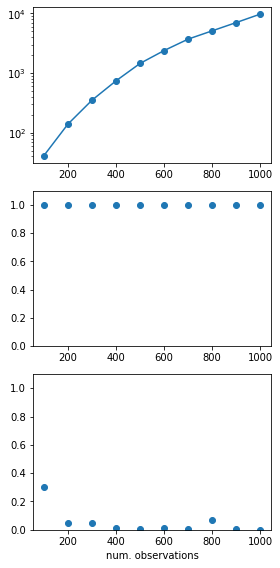

In [2201]:
fig,ax=plt.subplots(3,1, figsize=(4,8))
ax[0].semilogy(n, time_bkmr, '-o')
#ax[0].set_ylabel('time (seconds)')

ax[1].scatter(n, np.mean(mean_delta[:,0:2], axis=1))
ax[1].set_ylim(0,1.1)

ax[2].scatter(n, np.mean(mean_delta[:,2:4], axis=1))
ax[2].set_ylim(0,1.1)
ax[2].set_xlabel('num. observations')

plt.tight_layout()

In [2202]:
fig.savefig('scaling_bkmr.pdf')

In [2165]:
mean_delta[:,2:4]

array([[2.62747451e-01, 3.36732653e-01],
       [2.61947610e-02, 7.57848430e-02],
       [6.49870026e-02, 3.35932813e-02],
       [6.59868026e-03, 2.51949610e-02],
       [9.59808038e-03, 0.00000000e+00],
       [1.43971206e-02, 1.53969206e-02],
       [4.39912018e-03, 1.17976405e-02],
       [1.33573285e-01, 0.00000000e+00],
       [0.00000000e+00, 1.65966807e-02],
       [2.99940012e-03, 1.99960008e-04]])

In [2168]:
time_bkmr

array([  41.26215,  139.479  ,  351.1068 ,  741.9786 , 1453.6116 ,
       2389.6944 , 3716.136  , 5117.256  , 7044.732  , 9763.092  ])

In [2203]:
time_elapsed

array([53.83270001, 80.65322709, 79.09552693, 77.76384377, 90.15777516,
       91.44717622, 87.50025916, 87.07904601, 92.78316283, 90.88409114])